# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

from datetime import datetime
import collections

import numpy as np
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt

import os, pickle
import neo.io
import elephant

# analysis.py module in same folder
from bgcellmodels.common import units, analysis, signal as ephys_algos
from bgcellmodels.extensions.neo import signal as neoutil

# Functions formerly defined in notebook
from bgcellmodels.common.config_global import analysis_data as _data
from bgcellmodels.common.popsignal import *
# NOTE: aimport works after importing!
# So you can add this before a cell if you want to edit the function
# %aimport bgcellmodels.common.popsignal

units.set_units_module('quantities')
import quantities as pq

# Jupyter notebook extensions
%load_ext bgcellmodels.extensions.jupyter.skip_cell_extension

Using units module 'quantities'


## Plotting Options

In [2]:
# fix bug for notebook backend where figures not shown
if matplotlib.get_backend() == 'nbAgg':
    from bgcellmodels.extensions.jupyter import jupyterutil
    jupyterutil.notebook_show_figs_after_exception()

# Figure dimensions
fig_aspect_ratio = 8.0 / 3.0
page_width = 10
fig_width = 0.8 * page_width
fig_height = fig_width / fig_aspect_ratio
ax_width = 0.7 * page_width
ax_height = ax_width / fig_aspect_ratio

# Style of figures (default colors etc.): see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default')
style_color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Consistent size in backend 'notebook' (100 dpi) and 'inline' (72 dpi)
def plt_setrc():
    matplotlib.rcParams['savefig.dpi'] = 100
    matplotlib.rcParams['figure.dpi'] = 100

# from IPython.core.pylabtools import activate_matplotlib, backends
# def plt_backend(backend):
#     """
#     Alternative to cell magic '%matplotlib <backend>' that makes figure size consistent
#     """
#     activate_matplotlib(backends[backend])
#     plt_setrc()

_data.fig_width = fig_width
_data.fig_height = fig_height
_data.page_width = page_width
_data.ax_height = ax_height

In [3]:
class bcolors:
    """
    Example: print(bcolors.HEADER + 'hello' + bcolors.ENDC)
    """
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    ENDC = '\033[0m'    # termination sequence 

## Support Functions

In [4]:
def make_slice(interval, t_start, Ts):
    """
    Make slice object for addressing interval (a,b) in signal starting
    at t_start and recorded with sampling time Ts.
    """
    irange = [int((t-tstart)/Ts) for t in interval]
    return np.s_[irange[0]:irange[1]] # slice object

def make_spiketrains(pop_label, sig_label, threshold, check_plot=True):
    """
    Convert voltage signal to spike times using threshold detection
    """
    # Get the signal
    segment = pops_segments[pop_label]
    v_axterm = next((sig for sig in segment.analogsignals if sig.name == sig_label))

    # Plot to check
    if check_plot:
        cell_indices = range(10)
        plot_vm_signals(v_axterm, cell_indices, ROI_INTERVAL, title=sig_label)

    # Convert to Neo.SpikeTrain using threshold
    spike_trains = neoutil.make_spiketrains(
                            v_axterm, threshold=0.0,
                            annotations_simple=['source_population'],
                            annotations_indexable={
                                'source_ids':'source_id',
                                'source_indices':'source_index'})

    return spike_trains

# Import Data

## Import Settings

Define settings here or load from external python script by uncommenting second cell.

In [5]:
# !tree -L 3 -d /home/luye/Documents/sim_data/LuNetDBS/simdata_newsonic

In [6]:
# Manual configuration

# SETPARAM: path to simulation data
outputs = '/home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000'

# SETPARAM: time segment to load if split over multiple files
matfile_common_pattern = '-3000ms'

# SETPARAM: sweep value
sweep_var_name = 'dbs-phase'
sweep_var_value = '180'

# SETPARAM: region of interest (ROI) for plotting
ROI_INTERVAL = (1e3, 3e3)

# SETPARAM: reference phase 'from_ctx' / 'from_stn' / 'from_gpe' / float
reference_phase = {
    'method': 'from_ctx',
    'passband': (17.0, 23.0)
}

automatic_execution = False

In [7]:
# Automatic configuration: uncomment cell if settings from external configuration file

# conf_file = os.environ.get('NB_CONF_FILE', 'nb_exec_conf.py') # pass filename from calling script
# with open(conf_file) as conf:
#     conf_script = conf.read()
#     print("Contents of config file:\n" + conf_script)

# SETPARAM: as alternative, paste configuration file as text
# conf_script = """<paste here>"""

# Execute configuration script to load settings variables
# exec(conf_script)

## Export Settings

In [8]:
# SETPARAM: filename for numerical analysis results (pickle file)
outsuffix = '{:.1f}s-{:.1f}s'.format(ROI_INTERVAL[0]/1e3, ROI_INTERVAL[1]/1e3)
timestamp = datetime.now().strftime('%m.%d')
method = 'AUTO' if automatic_execution else 'MANUAL'
outbase = method + '-analysis_' + outsuffix + '_' + datetime.now().strftime('%Y.%m.%d-%H.%M.%S')
out_dir = os.path.join(outputs, 'analysis')
pickle_filename = 'analysis_results_{}_{}_{}.pkl'.format(outsuffix, timestamp, method)
_data.ROI_INTERVAL = ROI_INTERVAL

# SETPARAM: directory to save figures, set to None for no saving
parent_dir, _ = os.path.split(outputs)
_data.save_fig_path = save_fig_path = os.path.join(out_dir, 'figures_' + outbase) # None

# SETPARAM: whether to save figures
_data.export_figs = export_figs = not automatic_execution
if export_figs and not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)
    print("Created directory '{}'".format(save_fig_path))

Created directory '/home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31'


In [9]:
# SETPARAM: data that will be exported (choose dicts above)
exported_data = {}

# Raw signals
all_signals = {}   # neo.AnalogSignal variables
all_vm_signals = {}
all_lfp_signals = {}
all_sigmean = {}
all_spiketrains = {}
# Power
exported_data['PSD'] = all_psd = {}  # tuple[list[float]: freqs, list[float]: psd)
exported_data['spectrogram'] = all_spectrogram = {}
# Spike metrics
exported_data['mean_rate'] = all_mean_rate = {}
exported_data['unit_rates'] = all_unit_rates = {}
exported_data['burst_metrics'] = all_burst_metrics = {}
exported_data['stimlock_windows'] = all_stimlock_windows = {}
exported_data['PSTH_dbs'] = all_psth_dbs = {}
exported_data['stimlocked_spikes_dbs'] = all_spiketrain_stimlock = {}
# Misch
exported_data['I_exc_inh_ratio'] = all_I_exc_inh = {}
exported_data['I_afferents'] = all_I_afferents = {}
# Synchronization & phase
exported_data['cell_phase_vecs'] = all_cell_phase_vecs = {}
exported_data['pop_phase_vecs'] = all_pop_phase_vecs = {}
exported_data['Morgera_index'] = all_morgera = {}
exported_data['coherence_composite'] = all_comp_coherence = {} # dict['<pop A>-<pop B>', (fs: numpy.array, Cxy:numpy.array)]
exported_data['coherence_vmean'] = all_vmean_coherence = {}
# Metadata
exported_data['sim_config'] = None
exported_data['sweep_settings'] = {'var_name': sweep_var_name, 'var_value': sweep_var_value}
exported_data['analyzed_interval'] = ROI_INTERVAL
exported_data['populations'] = None


# Set global variables
_data.exported_data = exported_data

## Load Data

In [10]:
# File filter for Neo data files
file_filter = lambda f: f.endswith('.mat') and matfile_common_pattern in f

if isinstance(outputs, str):
    filenames = os.listdir(outputs)
    pop_files = [os.path.join(outputs, f) for f in filenames if file_filter(f)]
    params_file = next((os.path.join(outputs,f) for f in filenames if f.startswith('pop-parameters')), None)
else:
    # outputs is list[str] of paths to .mat files
    pop_files = outputs
    params_file = None

_data.pops_segments = pops_segments = {}
read_segment_id = 0

# Read binary files using Neo IO module
print("Reading data files:")
while len(pop_files) > 0:
    pop_file = pop_files.pop()
    reader = neo.io.get_io(pop_file)
    blocks = reader.read()
    assert len(blocks) == 1, "More than one Neo Block in file."
    pop_label = blocks[0].name
    
    # Read segment
    num_segments = len(blocks[0].segments)
    if read_segment_id >= num_segments:
        raise ValueError("Segment index greater than number of Neo segments in file {}".format(pop_file))
    segment = blocks[0].segments[read_segment_id]
    
    # Find other data files with same signals and merge into this segment
    sibling_files = [fp for fp in pop_files if fp[:-5] == pop_file[:-5]]
    if len(sibling_files) > 0:
        print("Merging signals from {} segments into {}".format(len(sibling_files), pop_label))
        for sig in segment.analogsignals:
            sig.segment = None # Hack: segment must be same -> set to None
        for sib_file in sibling_files:
            pop_files.remove(sib_file)
            reader = neo.io.get_io(sib_file)
            blocks = reader.read()
            sib_segment = blocks[0].segments[read_segment_id]
            for sig in sib_segment.analogsignals:
                sig.segment = None
                print('{} : {}'.format(sig.name, sig.annotations))
            segment.merge(sib_segment)
        del sib_segment
        del blocks
    
    # Save the segment in memory (dict)
    if pop_label in pops_segments:
        raise ValueError("Duplicate population labels in files")
    
    pops_segments[pop_label] = segment
    print("\n{} <-- {}".format(bcolors.OKGREEN + pop_label + bcolors.ENDC,
                               os.path.split(pop_file)[1]))

# Extract some signal metadata
exported_data['populations'] = pop_labels = pops_segments.keys()
_data.sim_dur = sim_dur = pops_segments['STN'].spiketrains[0].t_stop.magnitude

# Make all spike trains accessible by population
def spiketrains_by_gid(gids, pop_filter=None):
    if pop_filter is None:
        filter_func = lambda p: True
    elif isinstance(pop_filter, str):
        filter_func = lambda p: p.startswith(pop_filter)
    all_trains = sum([seg.spiketrains for pop, seg in pops_segments.items() if filter_func(pop)], [])
    return [st for st in all_trains if st.annotations['source_id'] in gids]

Reading data files:

STR.MSN <-- STR.MSN_0ms-3000ms_2019.08.07_18.54.55_scale-1.0_dur-3000.0_job-13295.mat

STN.surrogate <-- STN.surrogate_0ms-3000ms_2019.08.07_18.54.55_scale-1.0_dur-3000.0_job-13295.mat

GPE.surrogate <-- GPE.surrogate_0ms-3000ms_2019.08.07_18.54.55_scale-1.0_dur-3000.0_job-13295.mat

STN <-- STN_0ms-3000ms_2019.08.07_18.54.55_scale-1.0_dur-3000.0_job-13295.mat

CTX <-- CTX_0ms-3000ms_2019.08.07_18.54.55_scale-1.0_dur-3000.0_job-13295.mat

CTX.axons <-- CTX.axons_0ms-3000ms_2019.08.07_18.54.55_scale-1.0_dur-3000.0_job-13295.mat

GPE.proto <-- GPE.proto_0ms-3000ms_2019.08.07_18.54.55_scale-1.0_dur-3000.0_job-13295.mat


In [11]:
# Load the simulation config file
from bgcellmodels.common import fileutils
exported_data['sim_config'] = sim_config = fileutils.parse_json_file(
    os.path.join(outputs, 'simconfig', 'sim_config.json'), nonstrict=True)

# Check if segment contains bursting inputs
ctx_bursting_frac = sim_config['CTX']['spiking_pattern']['bursting_fraction']
ctx_burst_intervals = sim_config['CTX']['spiking_pattern']['intervals']
without_ctx_bursting = (
    (ctx_bursting_frac == 0)
    or all((ival[1] <= ROI_INTERVAL[0] for ival in ctx_burst_intervals))
    or all((ival[0] >= ROI_INTERVAL[1] for ival in ctx_burst_intervals))
)

In [12]:
# The recordings are saved in Neo format. See:
# http://neo.readthedocs.io/en/latest/
# http://neo.readthedocs.io/en/latest/api_reference.html#neo.core.AnalogSignal
# - Each segment has attributes 'analogsignals' and 'spiketrains'
# - Each quantity (e.g. AnalogSignal.signal) has attributes magnitude, units, dimensionality

# List all recorded signals
for pop_label, segment in pops_segments.items():
    print("\n{} has following signals:".format(pop_label))
    for signal in segment.analogsignals:
        print("\t- '{:10}\t[{}] - description: {}".format(signal.name, signal.units, signal.description))
    print("\t- {} spiketrains".format(len(segment.spiketrains)))


STN has following signals:
	- 'v_axnode0 	[1.0] - description: None
	- 'lfp       	[1.0] - description: None
	- 'v_axnodeneg1	[1.0] - description: None
	- 'v_axnodeneg2	[1.0] - description: None
	- 'Vm        	[1.0] - description: None
	- 'v_axterm  	[1.0] - description: None
	- 'gGABAA0   	[1.0] - description: None
	- 'gGABAA2   	[1.0] - description: None
	- 'gGABAA3   	[1.0] - description: None
	- 'gGABAA4   	[1.0] - description: None
	- 'gGABAA5   	[1.0] - description: None
	- 'gGABAA6   	[1.0] - description: None
	- 'gGABAA1   	[1.0] - description: None
	- 'g_NR2A0   	[1.0] - description: None
	- 'g_NR2A1   	[1.0] - description: None
	- 'g_NR2A2   	[1.0] - description: None
	- 'g_NR2A4   	[1.0] - description: None
	- 'g_NR2A5   	[1.0] - description: None
	- 'g_NR2A6   	[1.0] - description: None
	- 'g_NR2A7   	[1.0] - description: None
	- 'g_NR2A8   	[1.0] - description: None
	- 'g_NR2A9   	[1.0] - description: None
	- 'gGABAA7   	[1.0] - description: None
	- 'gGABAB5   	[1.0] - de

# Network Parameters

In [13]:
if params_file is not None:
    import pickle
    with open(params_file, 'rb') as pf:
        network_params = pickle.load(pf)
        _data.network_params = network_params
        print("Found parameters for following populations:\n"
              "{}\n".format(network_params.keys()))

    for pre_pop, pre_params in network_params.iteritems():
        if not isinstance(pre_params, dict):
            print("Ignoring entry: '{}'\n".format(pre_pop))
            continue
        for post_pop, pre_post_params in pre_params.iteritems():
            if 'conpair_pvals' in pre_post_params:
                print("Parameters for connection {} -> {}:\n"
                      "{}\n{}\n".format(pre_pop, post_pop,
                                        pre_post_params['conpair_pnames'], 
                                        pre_post_params['conpair_pvals'][:,2:].max(axis=0)))

Found parameters for following populations:
['STN', 'CTX', 'dopamine_depleted', 'STR.MSN', 'CTX.axons', 'GPE.surrogate', 'GPE.all', 'GPE.proto', 'STN.surrogate']

Parameters for connection STN -> GPE.proto:
['delay', 'weight', 'gmax_AMPA', 'gmax_NMDA']
[7.0e-01 1.0e+00 7.5e-04 0.0e+00]

Parameters for connection CTX -> CTX.axons:
['delay', 'weight']
[1. 1.]

Ignoring entry: 'dopamine_depleted'

Parameters for connection STR.MSN -> GPE.proto:
['delay', 'weight', 'gmax_GABAA']
[5.0e+00 1.0e+00 1.2e-03]

Parameters for connection CTX.axons -> STN:
['delay', 'weight']
[5.9 1. ]

Parameters for connection GPE.all -> STN:
['delay', 'weight', 'gmax_GABAA', 'gmax_GABAB']
[0.7       1.        0.018     0.0037485]

Parameters for connection GPE.all -> GPE.proto:
['delay', 'weight', 'gmax_GABAA', 'gmax_GABAB']
[1.0e-01 1.0e+00 8.0e-04 1.6e-04]



/home/luye/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


## Connection Matrices

In [14]:
with_connection_plots = False

# Print STN-GPE connection matrix
skip_targets = 'GPE.axons', 'CTX.axons'
for pre_pop, pre_params in network_params.iteritems():
    if not isinstance(pre_params, dict):
        continue
    for post_pop, pre_post_params in pre_params.iteritems():
        if post_pop in skip_targets:
            continue
        if with_connection_plots and ('conn_matrix' in pre_post_params):
            adjacency_mat = pre_post_params['conn_matrix']
            divx = max(3, adjacency_mat.shape[1]/10)
            divy = max(3, adjacency_mat.shape[0]/10)
            analysis.plot_connectivity_matrix(adjacency_mat, 
                                              pop0=pre_pop, pop1=post_pop,
                                              px=divx, py=divy,
                                              title='{} -> {}'.format(pre_pop, post_pop))

# for pops in [('STN', 'GPE'), ('GPE', 'STN'), ('GPE', 'GPE'), ('STN', 'STN')]:
#     stn_gpe_weights = network_params[pops[0]][pops[1]]['conn_matrix']
#     analysis.plot_connectivity_matrix(stn_gpe_weights, pop0=pops[0], pop1=pops[1], pop_size=100, seaborn=False)

# Raw Signals

In [15]:
# %matplotlib notebook
# plt_setrc()

In [16]:
def plot_lfp_signal(lfp_signal, pop_label, t_interval=ROI_INTERVAL):
    # Plot LFP
    islice = neoutil.make_slice(lfp_signal, t_interval)

    fig, ax = plt.subplots(figsize=(page_width, ax_height))
    ax.plot(lfp_signal.times[islice], lfp_signal[islice], label='{} LFP'.format(pop_label))

    # ax.set_ylim((-0.5, 4.0))
    ax.set_xlim(t_interval)
    ax.set_ylabel('LFP magnitude ({})'.format(lfp_signal.units))
    ax.set_xlabel('time ({})'.format(lfp_signal.times.units))
    ax.set_title('{} LFP contribution'.format(pop_label))
    ax.grid(True)

## DBS Signal

Plot DBS signal and stimulus-locked spiking or other signals.

In [17]:
from bgcellmodels.emfield import stimulation

emf_params = sim_config['electromagnetics']
amp0 = emf_params['dbs_pulse0_amplitude_mA']
amp1 = emf_params['dbs_pulse1_amplitude_mA']
dbs_freq = emf_params['dbs_frequency_hz']
dbs_IPI = 1e3 / dbs_freq

# Create DBS signal if not recorded
dbs_amp, dbs_time = stimulation.make_pulse_train(
                                    frequency=emf_params['dbs_frequency_hz'],
                                    phase_deg=emf_params.get('dbs_phase_deg', 0.0),
                                    pulse_width_ms=emf_params['dbs_pulse_width_ms'],
                                    amp0=emf_params['dbs_pulse0_amplitude_mA'],
                                    amp1=emf_params['dbs_pulse1_amplitude_mA'],
                                    dt=emf_params['dbs_sample_period_ms'],
                                    duration=sim_dur,
                                    off_intervals=emf_params['dbs_off_intervals'],
                                    coincident_discontinuities=True)

onset_indices = np.where(np.diff((dbs_amp == amp0).astype(float)) == 1)[0] + 1
dbs_onset_times = dbs_time[onset_indices]

# Make DBS AnalogSignal
dbs_signal = neo.AnalogSignal(dbs_amp.reshape((-1,1)),
                    units='mA',
                    sampling_period=emf_params['dbs_sample_period_ms']*pq.ms,
                    t_start=dbs_time[0], t_stop=dbs_time[-1])

dbs_onset_spiketrain = neo.SpikeTrain(dbs_onset_times,
                        t_start=dbs_time[0], t_stop=dbs_time[-1],
                        units='ms', name='DBS.onset')

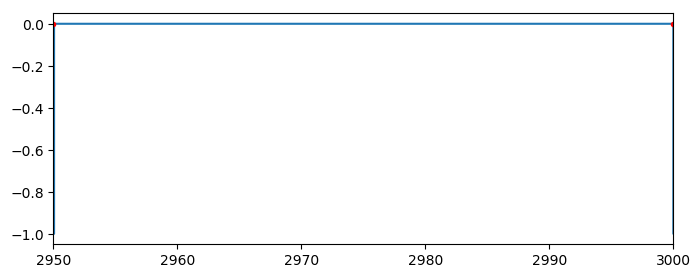

In [18]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Plot DBS amplitude
ax.plot(dbs_time, dbs_amp)
ax.set_xlim((ROI_INTERVAL[1]-50, ROI_INTERVAL[1]))

# Mark onset times
marker_heights = np.zeros_like(dbs_onset_times) + max(amp0, amp1) + 0.25 * max(amp0, amp1)
ax.plot(dbs_onset_times, marker_heights, 'r.')
# ax.vlines(onset_times, amp0*1.2, amp1*1.2, color='red')

## LFP

In [19]:
# Calculate total LFP signal from all contributing cells

test_lfp = next((sig for sig in pops_segments['STN'].analogsignals if sig.name == 'lfp'), None)
WITH_LFP = test_lfp is not None

if WITH_LFP:
    # Sum all recorded LFP signals from all cells
    lfp_array_total = sum((
        sig.as_array().sum(axis=1).reshape((-1,1)) 
            for seg in pops_segments.values() 
                for sig in seg.analogsignals if sig.name == 'lfp')
    )

    lfp_signal_total = test_lfp.duplicate_with_new_array(lfp_array_total)
    all_lfp_signals['LFP.all'] = lfp_signal_total

**LFP - filter design**

/home/luye/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


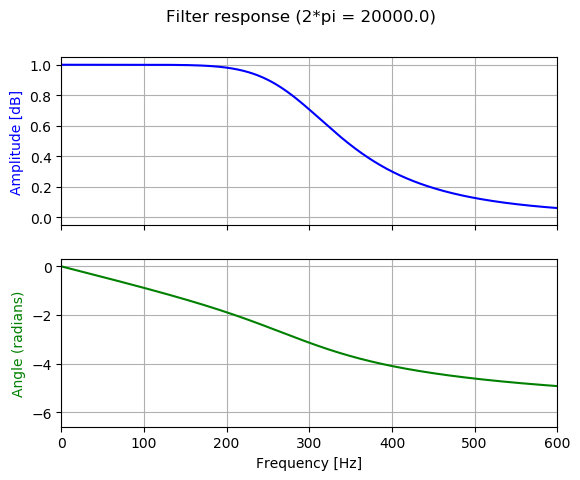

In [20]:
# Band-pass filter in frequency band where we want to measure phase differences
Fs = float(lfp_signal_total.sampling_rate.rescale('Hz').magnitude)
Fn = Fs / 2. # Nyquist frequency

hpfreq, lpfreq = 1.0, 300.0
order = 4

# NOTE: using filtfilt/sosfiltfilt, the phase shift is corrected
assert hpfreq < lpfreq
low, high = hpfreq / Fn, lpfreq / Fn
lfp_filter_sos = sos = scipy.signal.butter(
    order, high, btype='lowpass', analog=False, output='sos')

# Plot filter response
w, h = scipy.signal.sosfreqz(sos, np.linspace(0, np.pi, 2**np.ceil(np.log2(Fn))))
angles = np.unwrap(np.angle(h))
fax = w * Fn / (np.pi)

fig, ax = plt.subplots(2, 1, sharex=True)
fig.suptitle("Filter response (2*pi = {})".format(Fs))

ax[0].plot(fax, abs(h), 'b') # 20 * np.log10(abs(h))
ax[0].set_ylabel('Amplitude [dB]', color='b')
ax[0].grid(True)

ax[1].plot(fax, angles, 'g')
ax[1].set_ylabel('Angle (radians)', color='g')
ax[1].set_xlim((0, lpfreq * 2.0))
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(True)

### plot total

Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31/lfp-LFP.all_t-1.8-2.1.pdf


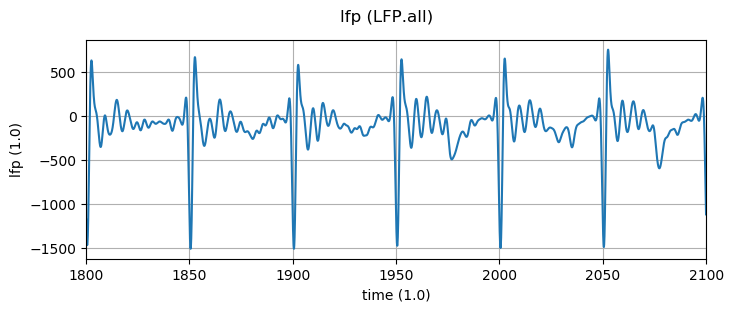

In [21]:
# Calculate total LFP signal from all contributing cells
if WITH_LFP:
    
    # Filter LFP
    signal = lfp_signal_total
    lfp_bp = signal.duplicate_with_new_array(
                scipy.signal.sosfiltfilt(lfp_filter_sos, signal.as_array(), axis=0))

    # Plot LFP signal
    t_interval = [ROI_INTERVAL[0] + 800, ROI_INTERVAL[0] + 1100.0]
    plot_signal(lfp_bp, t_interval, pop_label='LFP.all', title=True, export=True)

In [22]:
# ARTICLE
# for pop_label in 'LFP.all', 'STN', 'GPE.proto', 'CTX.axons':
#     t_interval = [ROI_INTERVAL[0] + 900, ROI_INTERVAL[0] + 1100.0]
#     plot_signal(all_lfp_signals[pop_label], t_interval, pop_label=pop_label, title=True, export=True)

## STN - soma, axon

**Somatic Vm**

In [23]:
pop_label = 'STN'
segment = pops_segments[pop_label]
signal = stn_vm_signal = next((sig for sig in segment.analogsignals if sig.name == 'Vm'))
all_vm_signals[pop_label] = signal
all_sigmean[pop_label + '_Vm'] = signal.duplicate_with_new_array(signal.mean(axis=1).reshape((-1,1)))

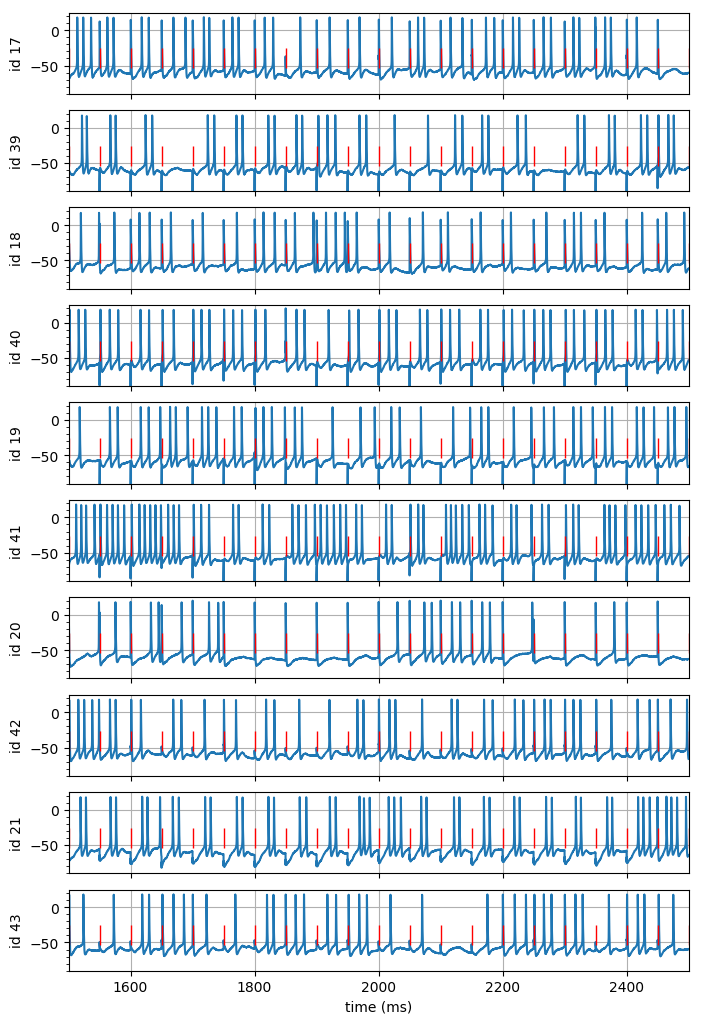

In [24]:
# Plot membrane voltage
max_num_plot = 10
num_signals = min(signal.shape[1], max_num_plot)
interval = (ROI_INTERVAL[0] + 500.0, ROI_INTERVAL[0] + 1500.0) # SETPARAM: plot interval
cell_indices = np.arange(num_signals) + 40
plot_vm_signals(stn_vm_signal, cell_indices, interval, interval_only=False,
                trigger=dbs_onset_times, title='STN soma Vm')

### SEPs - article

Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31/Vm-sigs_STN_gids-22-23-47-3-11-26.pdf


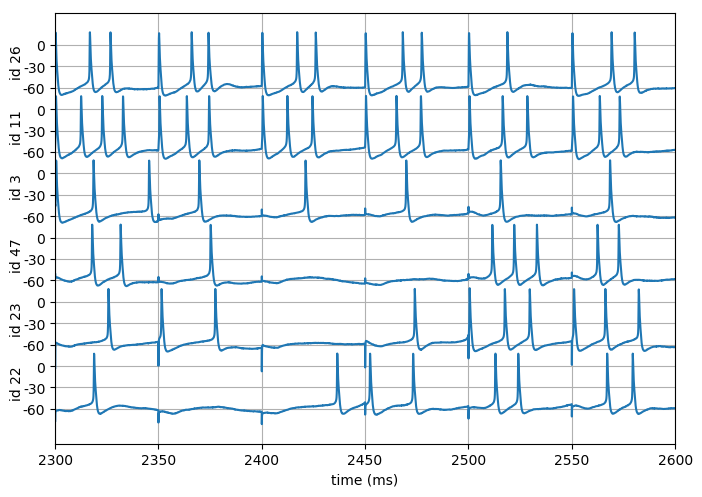

In [25]:
# Plot membrane voltage
if not automatic_execution:
    interval = (2300.0, 2600.0) # SETPARAM: plot interval
    
    # Classify spike trains
    neg_silent = [22, 10, 43, 19]
    pos_silent = [47, 48, 33]
    neg_sparse = [23, 24, 25, 4, 5, 6, 49, 37, 15, 41, 40, 39]
    pos_sparse = [3, 46, 1, 2, 45, 44, 0, 38, 34, 35, 13, 34, 42, 17]
    pos_lock_full = [26, 27, 28, 29, 36, 12, 20, 18]
    pos_lock_part = [11, 32, 31, 9, 30, 8, 7, 16, 14]
    pop_gids = sum((gids[:1] for gids in (neg_silent, neg_sparse, pos_silent, pos_sparse,
                    pos_lock_part, pos_lock_full)), [])# 6, 7, 8, 10, 25, 26, 30, 47
    
    plot_vm_signals(stn_vm_signal, pop_gids, interval, as_gids=True, interval_only=True,
                    trigger=None, ylim=(-60.0, 30.0), dy_major=30, 
                    title='STN soma Vm', figsize=(fig_width, .75*ax_height), export=True,
                    multiple_axes=False, color=style_color_cycle[0])

**Pre-synaptic Vterm**

GPE gids : [56, 59, 61, 63, 67, 102, 143, 85]


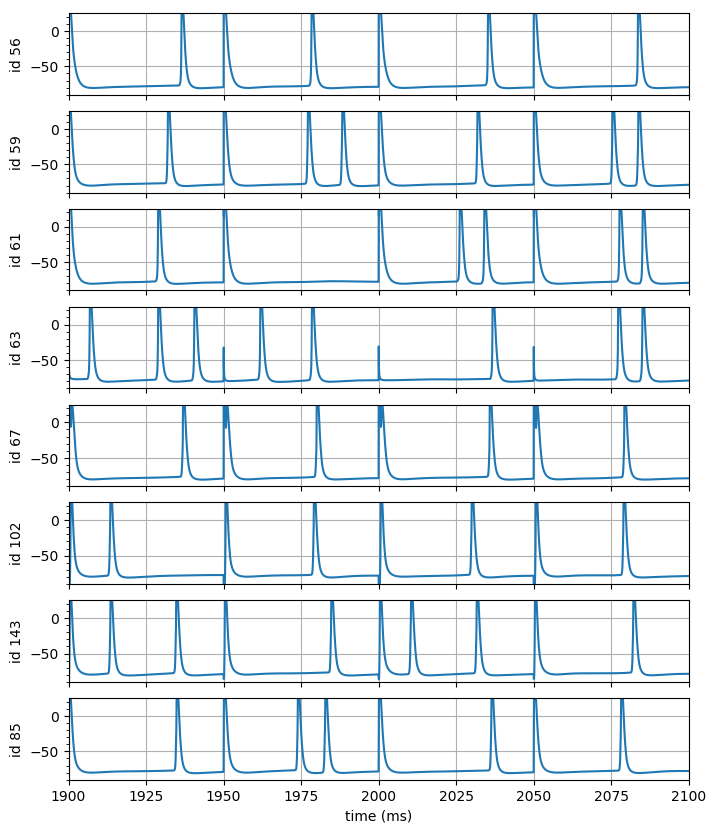

In [26]:
# Plot pre-synaptic terminal signal for chosen cells
if not automatic_execution:
    stn_gid = 28
    gpe_all_inds = get_presynaptic_pop_indices(stn_gid, 'GPE.all', 'STN')
    gpe_proto_gids = [network_params['GPE.all']['gids'][i] for i in gpe_all_inds]
    print("GPE gids : {}".format(gpe_proto_gids))

    gpe_signal = next((sig for sig in pops_segments['GPE.proto'].analogsignals if sig.name == 'v_axterm'))
    gpe_sig_indices = [gpe_signal.annotations['source_ids'].tolist().index(gid) for gid in gpe_proto_gids]

    # Plot presynaptic signals
    interval = [1900.0, 2100.0]
    plot_vm_signals(gpe_signal, gpe_sig_indices, interval, title='GPe axon terminal')

**STN - axonal**

STN efferent axons, i.e. STN->GPe projecting.

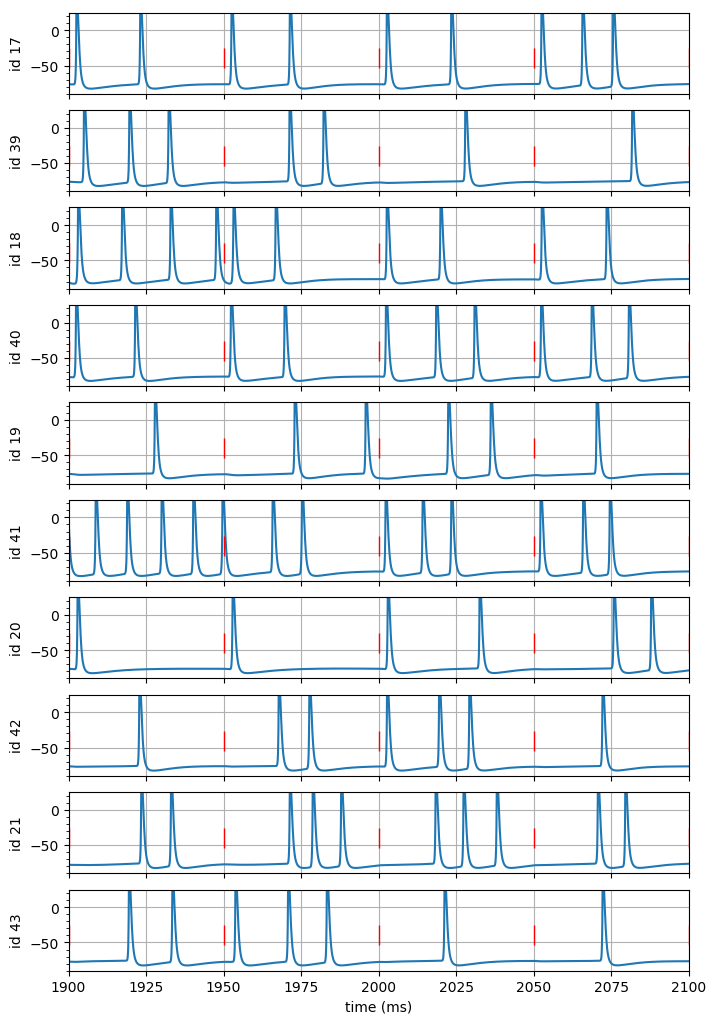

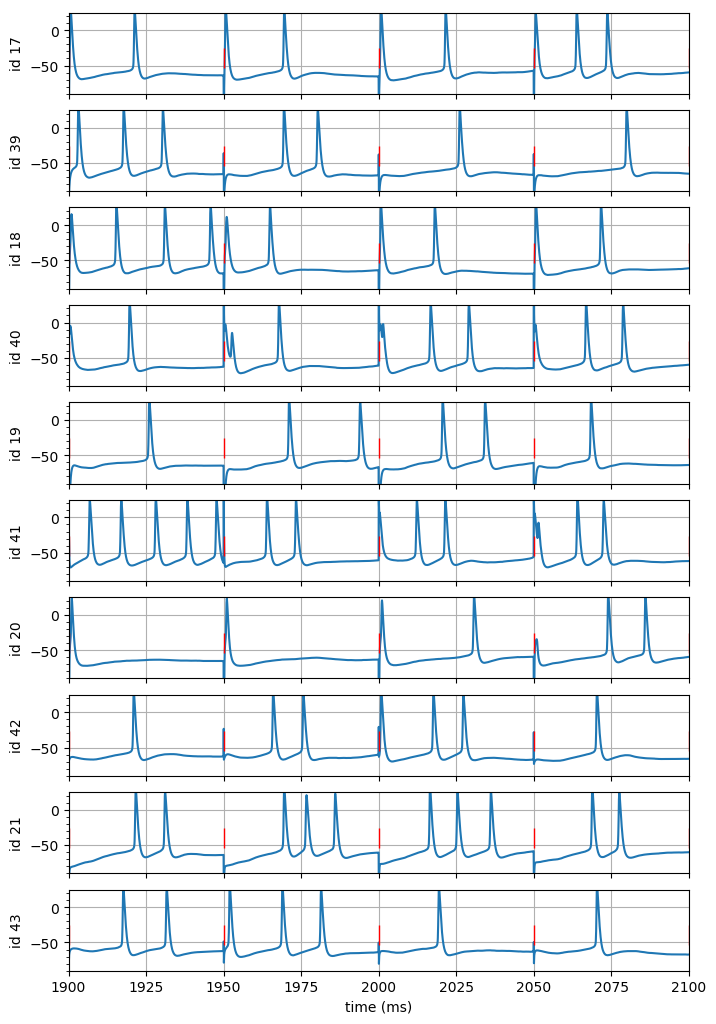

In [27]:
signal = next((sig for sig in segment.analogsignals if sig.name == 'v_axterm'))
plot_vm_signals(signal, cell_indices, interval, trigger=dbs_onset_times,
                interval_only=False, title='STN axon terminal')

signal = next((sig for sig in segment.analogsignals if sig.name.startswith('v_ax') and sig.name != 'v_axterm'))
plot_vm_signals(signal, cell_indices, interval, trigger=dbs_onset_times, 
                interval_only=False, title=signal.name)

### LFP contribution

Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31/lfp-STN_t-1.8-2.1.pdf


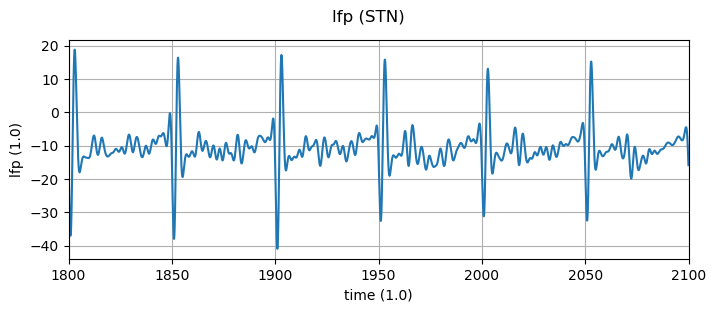

In [28]:
# Plot LFP Contribution
pop_label = 'STN'
lfp_contributions = next((sig for sig in pops_segments[pop_label].analogsignals if sig.name == 'lfp'), None)

WITH_LFP = lfp_contributions is not None

if WITH_LFP:
    # Calculate population LFP signal
    lfp_signal = lfp_contributions.duplicate_with_new_array(lfp_contributions.sum(axis=1).reshape((-1,1)))
    all_lfp_signals[pop_label] = lfp_signal
    
    # Filter LFP
    signal = lfp_signal
    lfp_bp = signal.duplicate_with_new_array(
                scipy.signal.sosfiltfilt(lfp_filter_sos, signal.as_array(), axis=0))

    # Plot LFP
    t_interval = [ROI_INTERVAL[0] + 800, ROI_INTERVAL[0] + 1100.0]
    plot_signal(lfp_bp, t_interval, pop_label=pop_label, title=True, export=True)


## GPE - soma, axon

In [29]:
pop_label = 'GPE.proto'
segment = pops_segments[pop_label]
all_vm_signals[pop_label] = gpe_vm_signal = signal = next((sig for sig in segment.analogsignals if sig.name == 'Vm'))
all_sigmean[pop_label + '_Vm'] = signal.duplicate_with_new_array(signal.mean(axis=1).reshape((-1,1)))

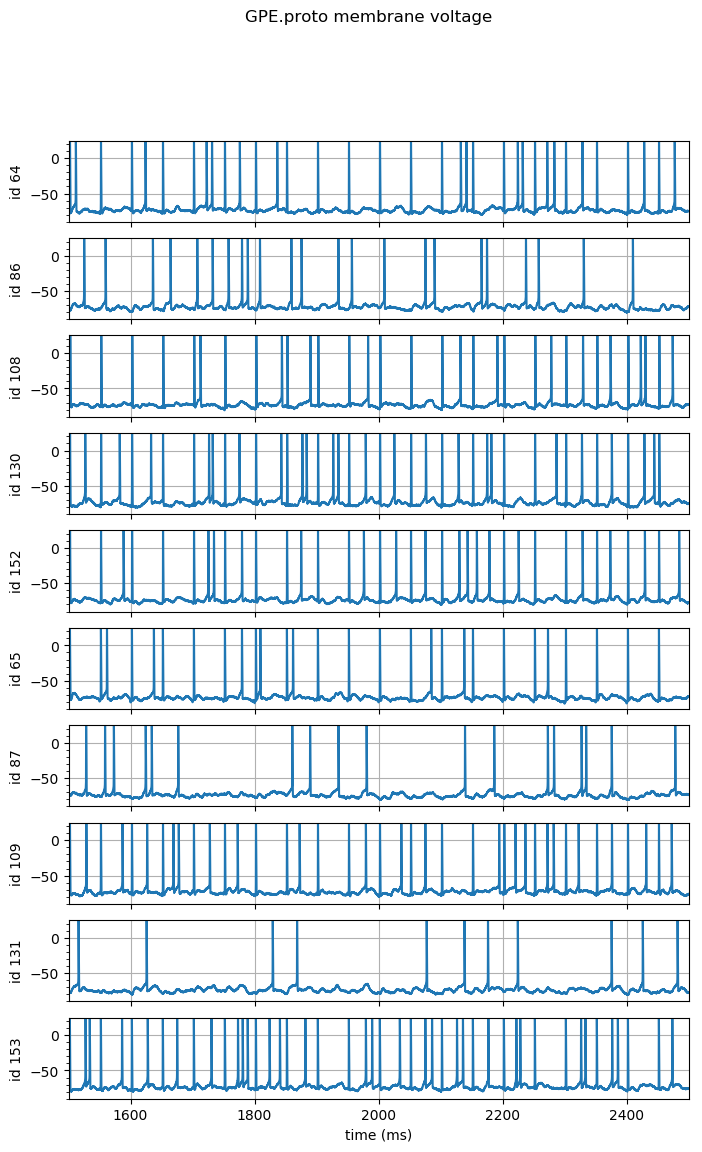

In [30]:
# Choose plot interval and cell indices
max_num_plot = 10
num_signals = min(signal.shape[1], max_num_plot)
interval = (ROI_INTERVAL[0] + 500.0, ROI_INTERVAL[0] + 1500.0)
cell_indices = np.arange(num_signals) + 90
plot_vm_signals(gpe_vm_signal, cell_indices, interval)

### SEPs - article

Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31/Vm-sigs_GPE.proto_gids-112-88-56.pdf


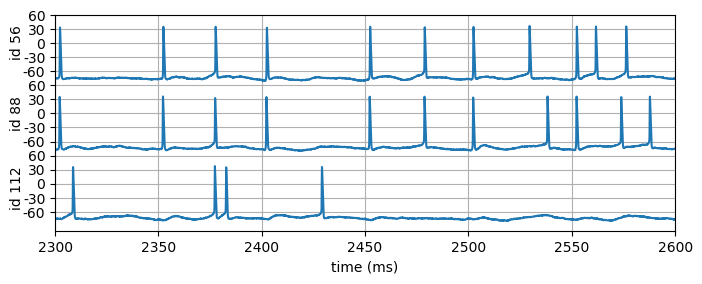

In [31]:
# Plot membrane voltage
if not automatic_execution:
    interval = (2300.0, 2600.0) # SETPARAM: plot interval
    
    # Classify spike trains
    neg_silent = []
    pos_silent = []
    neg_sparse = []
    pos_sparse = [112, 113, 132, 111, 68, 116, 138, 73, 96, 76, 98, 78, 
                  79, 101, 80, 60, 82, 148, 106, 107, 63, 86, 97, 131]
    pos_lock_part = [88, 110, 93, 136, 95, 55, 144, 125, 81, 152]
    
    # Remaining cells are fully entrained
    pos_lock_full = set([ i for i in network_params['GPE.proto']['gids'] if i < 1000])
    for gids in pos_sparse, pos_lock_part:
        pos_lock_full -= set(gids)
    pos_lock_full = list(pos_lock_full)
    
    pop_gids = sum((gids[:1] for gids in (pos_sparse, pos_lock_part, pos_lock_full)), [])
    
    plot_vm_signals(gpe_vm_signal, pop_gids, interval, as_gids=True, interval_only=True,
                    trigger=None, ylim=(-60.0, 90.0), dy_major=30, 
                    title='GPe soma Vm', figsize=(fig_width, .75*ax_height), export=True,
                    multiple_axes=False, color=style_color_cycle[0])

**GPE - axon**

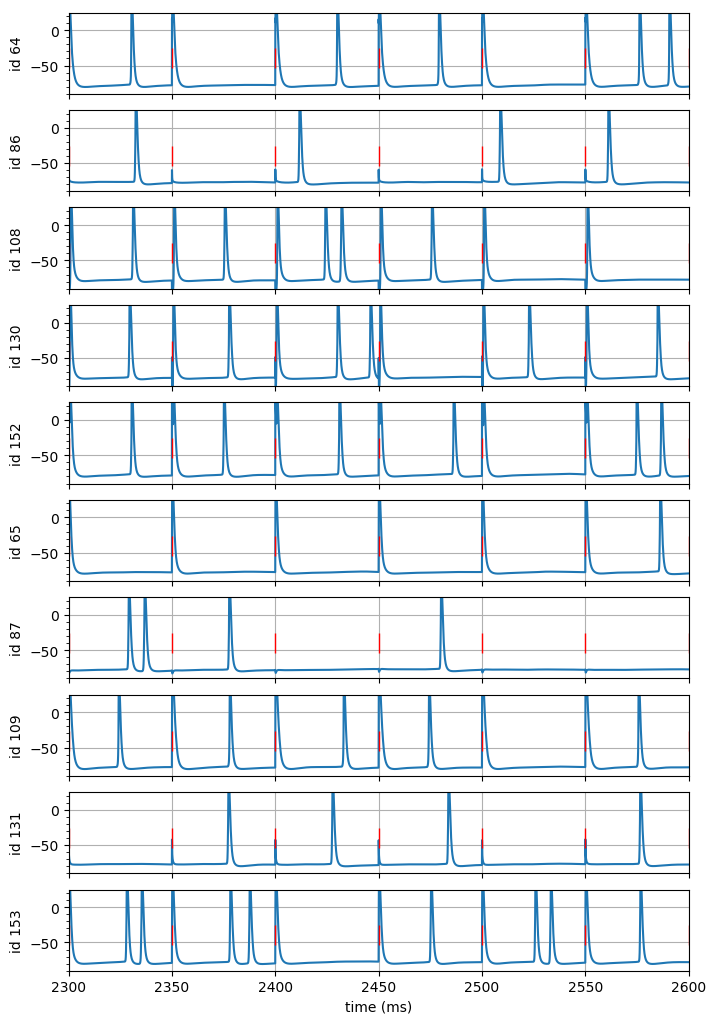

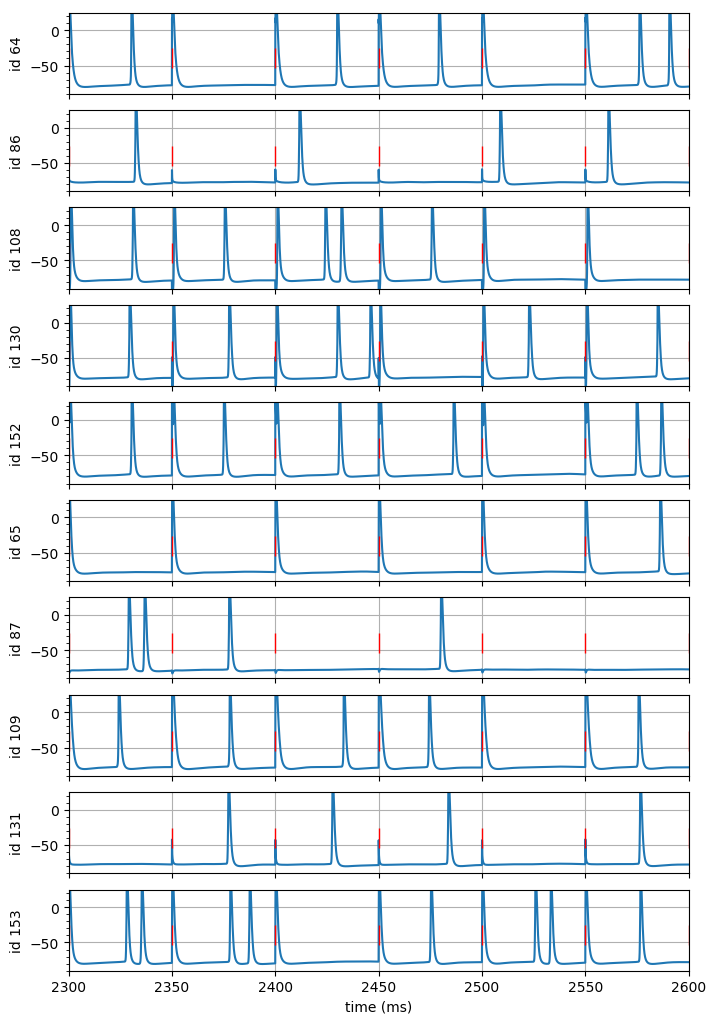

In [32]:
signal = next((sig for sig in segment.analogsignals if sig.name == 'v_axterm'))
plot_vm_signals(signal, cell_indices, interval, trigger=dbs_onset_times,
                interval_only=False, title=signal.name)

signal = next((sig for sig in segment.analogsignals if sig.name.startswith('v_ax') and sig.name != 'v_axterm'))
plot_vm_signals(signal, cell_indices, interval, trigger=dbs_onset_times, 
                interval_only=False, title=signal.name)

### LFP contribution

Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31/lfp-GPE.proto_t-1.8-2.1.pdf


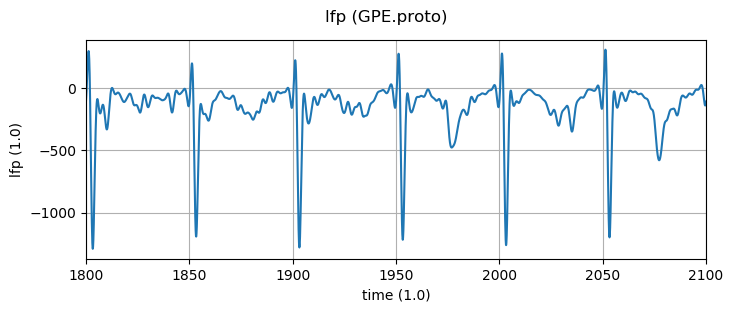

In [33]:
# Plot LFP Contribution
pop_label = 'GPE.proto'
lfp_contributions = next((sig for sig in pops_segments[pop_label].analogsignals if sig.name == 'lfp'), None)

if lfp_contributions is not None:
    # Calculate population LFP signal
    lfp_signal = lfp_contributions.duplicate_with_new_array(lfp_contributions.sum(axis=1).reshape((-1,1)))
    all_lfp_signals[pop_label] = lfp_signal
    
    # Filter LFP
    signal = lfp_signal
    lfp_bp = signal.duplicate_with_new_array(
                scipy.signal.sosfiltfilt(lfp_filter_sos, signal.as_array(), axis=0))

    # Plot LFP
    t_interval = [ROI_INTERVAL[0] + 800, ROI_INTERVAL[0] + 1100.0]
    plot_signal(lfp_bp, t_interval, pop_label=pop_label, title=True, export=True)


## CTX - soma, axon

Artificial cortical voltage traces: Convolve spike times with stereotypical AP to obtain artificial voltage signal.

In [34]:
pop_label = 'CTX'
segment = pops_segments['CTX']
spiketrains = segment.spiketrains[0:100] # select subset of spiketrains

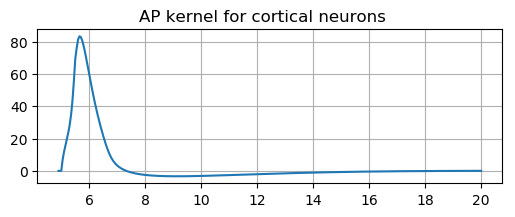

In [35]:
# Load Pyramidal cell action potential from saved recording
pyramidal_trace = np.loadtxt('../../KlmnNetMorpho/analysis/pyramidal.dat')
vm = pyramidal_trace[:,1]
tvec = pyramidal_trace[:,0]
dt = np.round(tvec[1] - tvec[0], 4)
ap_t_interval = [4.9, 20.0]
ap_i_interval = [int(t/dt) for t in ap_t_interval]
subsample = 2
ap_range = range(ap_i_interval[0], ap_i_interval[1]+1, subsample)
ap_kernel = vm[ap_range]
ap_baseline = -65.0
ap_kernel -= ap_baseline # center on 0 for convolution

plt.figure(figsize=(6,2))
plt.plot(tvec[ap_range], ap_kernel)
plt.suptitle('AP kernel for cortical neurons')
plt.grid(True)

In [36]:
# Construct AnalogSignal of N channels from N spiketrains
dur = np.round(spiketrains[0].duration.magnitude, 4)
tstart = np.round(spiketrains[0].t_start.magnitude, 4)
tstop = np.round(spiketrains[0].t_stop.magnitude, 4)
dt = stn_vm_signal.sampling_period.magnitude
signal_matrix = np.empty((int(dur/dt)+1, len(spiketrains)))

# Convolution operation for each spiketrain
for i, st in enumerate(spiketrains):
    
    time = np.arange(tstart, tstop + dt, dt)
    spiketimes = st.times.magnitude
    spike_pulses = np.zeros_like(time)
    spike_pulses[[int((t-tstart)/dt) for t in spiketimes]] = 1.0
    
    # Convole pulses at spike times with AP kernel
    spike_signal = np.convolve(spike_pulses, ap_kernel, mode='same') + ap_baseline
    signal_matrix[:, i] = spike_signal[:signal_matrix.shape[0]]
    assert (abs(signal_matrix.shape[0] - spike_signal.size) <= 2)

# Resulting Neo signals
ctx_vm_signal = neo.AnalogSignal(signal_matrix, name='Vm', units='mV', sampling_period=dt*pq.ms,
                                t_start=spiketrains[0].t_start, t_stop=spiketrains[0].t_stop)
ctx_vm_signal.annotations['source_population'] = 'CTX'
all_vm_signals[pop_label] = ctx_vm_signal

# ctx_vm_mean = ctx_vm_signal.sum(axis=1) / ctx_vm_signal.shape[1]
ctx_vm_mean = signal.duplicate_with_new_array(ctx_vm_signal.mean(axis=1).reshape((-1,1)))
all_sigmean[pop_label + '_Vm'] = ctx_vm_mean

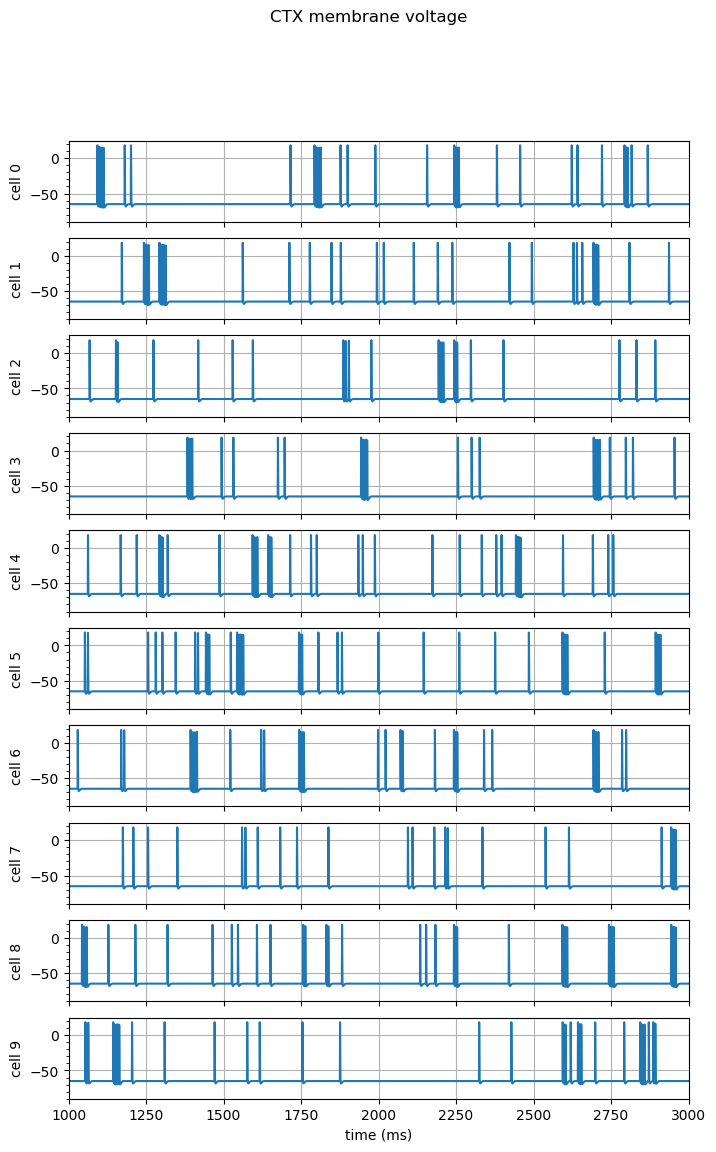

In [37]:
# Plot artificial signal to verify
max_num_plot = 10
num_signals = min(ctx_vm_signal.shape[1], max_num_plot)
interval = ROI_INTERVAL # [12.75e3, 14e3]
cell_indices = range(num_signals)
plot_vm_signals(ctx_vm_signal, cell_indices, interval, interval_only=False)

**CTX - axon**

In [38]:
pop_label = 'CTX.axons'
segment = pops_segments[pop_label]

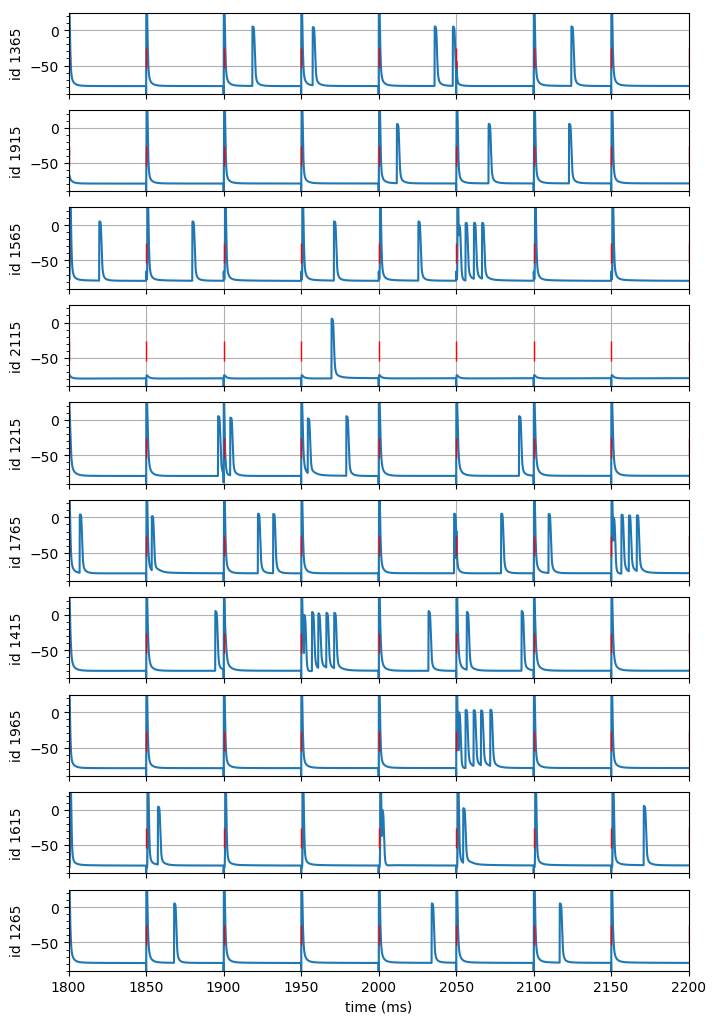

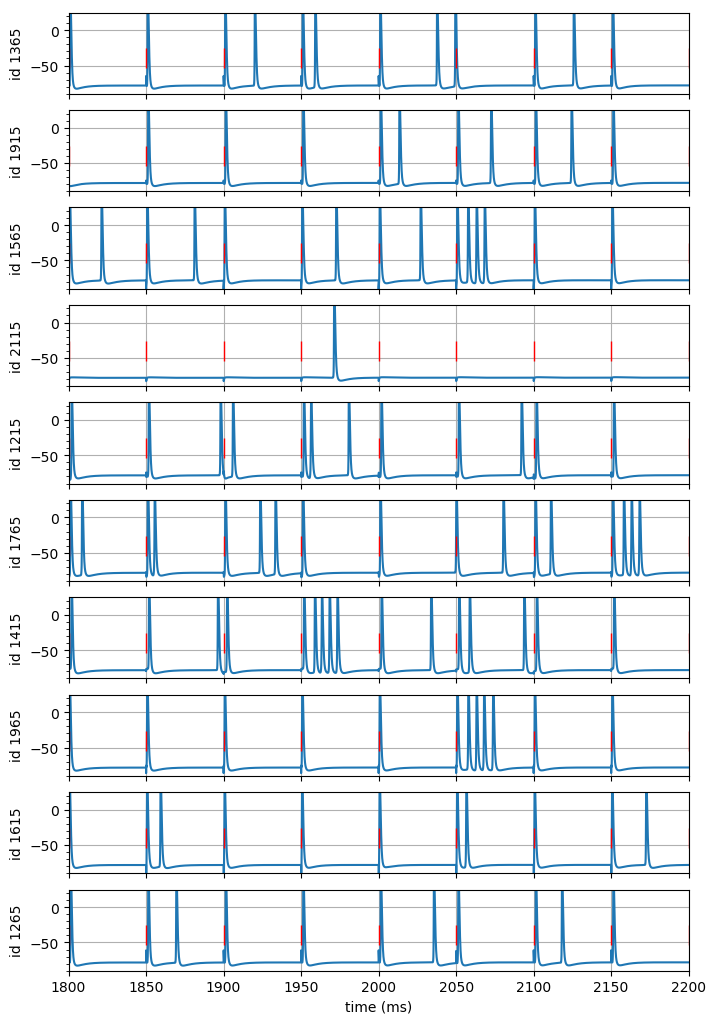

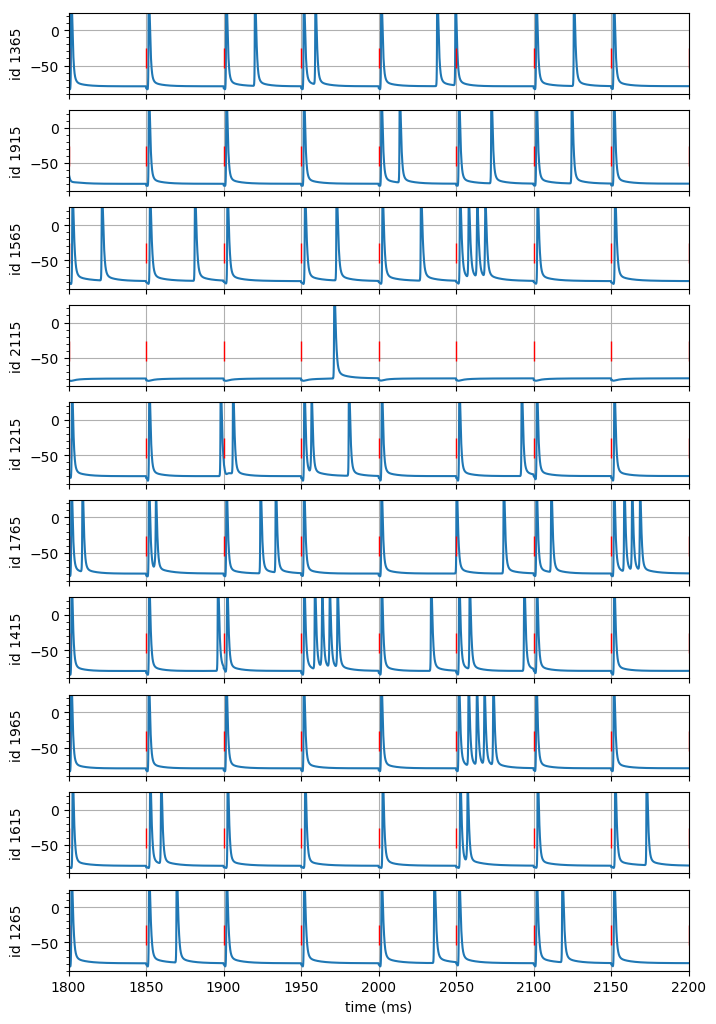

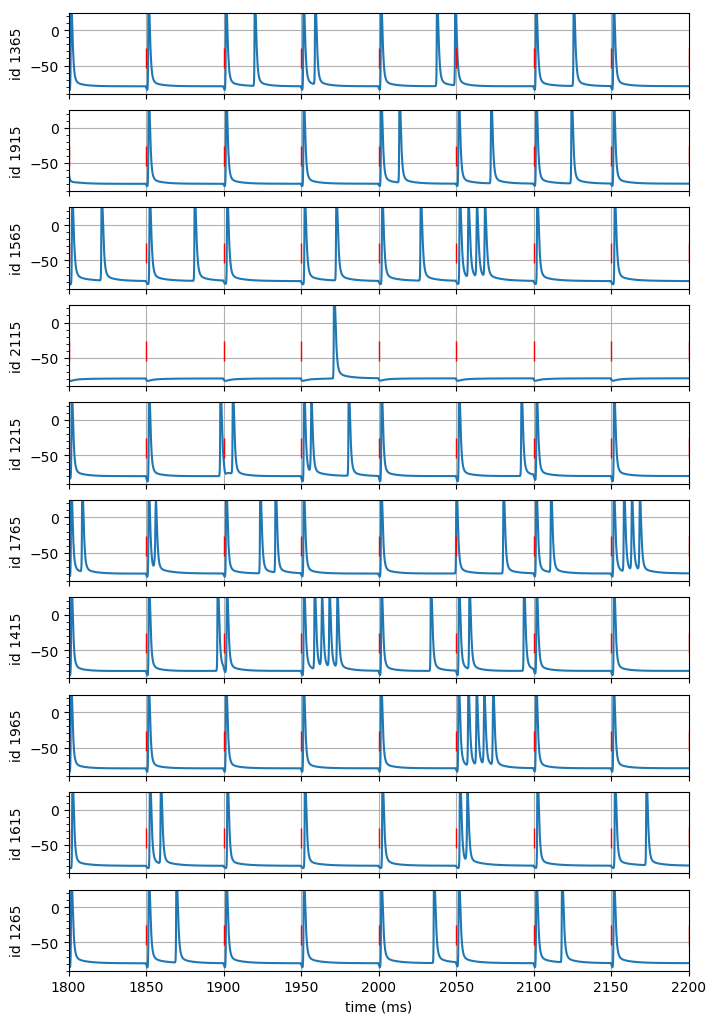

In [39]:
sig_names = [sig.name for sig in segment.analogsignals if sig.name.startswith('v_ax')]
interval = (ROI_INTERVAL[0] + 800.0, ROI_INTERVAL[0] + 1200.0)

for sig_name in sig_names:
    signal = next((sig for sig in segment.analogsignals if sig.name == sig_name))
    plot_vm_signals(signal, cell_indices, interval, trigger=dbs_onset_times,
                    interval_only=False, title=signal.name)

**CTX.axons - LFP contribution**

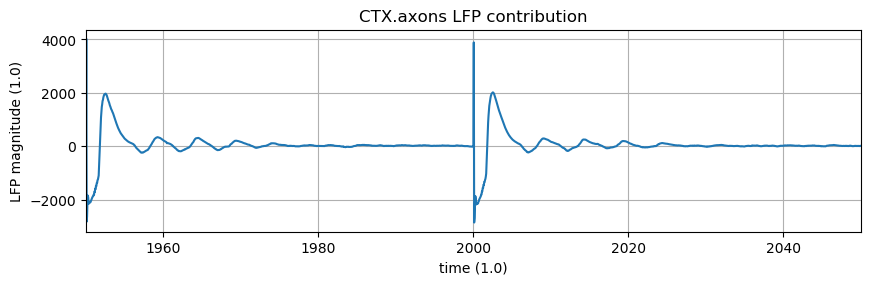

In [40]:
# Plot LFP Contribution
lfp_contributions = next((sig for sig in pops_segments[pop_label].analogsignals if sig.name == 'lfp'), None)

if lfp_contributions is not None:
    # Calculate population LFP signal
    lfp_signal = lfp_contributions.duplicate_with_new_array(lfp_contributions.sum(axis=1).reshape((-1,1)))
    all_lfp_signals[pop_label] = lfp_signal

    # Plot LFP
    t_interval = [ROI_INTERVAL[0] + 950, ROI_INTERVAL[0] + 1050.0]
    plot_lfp_signal(lfp_signal, pop_label, t_interval)


# Spike Trains

<span style='color:red;font-weight:bold'>WARNING</SPAN>: In rastergram plots, note the number of spike trains plotted (see y-axis). If it is too high you get overlapping marker bars (marker height is larger than row height allocated to one spiketrain). This leads to misleading plots as spiketrains are overlapping which looks like an artificially elevated firing rate.

In [41]:
# %matplotlib inline
# plt_setrc()

## Functions

In [42]:
def plot_stimlock_fractions(fractions, pop_label='Cell', activation_threshold=0.8):
    """
    Histogram plot of stimulus-locked spike fractions in population.
    """
    bin_counts, bin_edges = np.histogram(fractions, bins=np.arange(0,1.1,0.05))
    bin_fractions = bin_counts.astype(float) / np.sum(bin_counts)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = np.diff(bin_edges)[0]
    
    cdf_activation = np.cumsum(bin_fractions[::-1])
    cdf_xvals = bin_edges[-2::-1]
    
    # act_fraction = sum((1.0 for f in fractions if f >= activation_threshold)) / len(fractions)
    act_mask = (bin_edges >= activation_threshold)[:-1]
    act_fraction = np.sum(bin_counts[act_mask], dtype=float) / np.sum(bin_counts)
    print("{} : fraction cells activated (threshold {}) = {}".format(
          pop_label, activation_threshold, act_fraction))

    fig, ax = plt.subplots(figsize=(page_width*0.6, 3.0))
    ax.bar(bin_centers * 100, bin_fractions * 100, width=bin_width * 100, edgecolor=None)
    ax.plot(cdf_xvals * 100, cdf_activation * 100, color='k')
    
    ax.set_title('DBS neurite activation ({})'.format(pop_label))
    ax.set_ylabel('frequency (%)')
    ax.set_xlabel('stimulus-locked spikes (%)')
    ax.set_xticks(range(0, 105, 5), minor=True)
    ax.set_xticks(range(0, 110, 10), minor=False)
    ax.set_ylim((0, 110 * bin_fractions.max()))
    ax.grid(True, axis='both', which='both')
    fig.subplots_adjust(bottom=0.15) # prevent clipping of xlabel
    return fig, ax


def plot_propagation_delays(trains_start, trains_end, bin_width=0.25, bin_range=(0, 5)):
    """
    Measure propagation delays between spike times in train A and B.
    The algorithm discards pairs of spike trains that do not have an equal number of spikes
    """
    assert len(trains_start) == len(trains_end)
    all_delays = []
    
    # Delays between each pair of spike trains (start vs end of axon)
    num_nonmatching = 0
    reliability = 0.0
    for train_a, train_b in zip(trains_start, trains_end):
        times_a = train_a.as_array()
        times_b = train_b.as_array()
        if times_a.shape != times_b.shape:
            num_nonmatching += 1
            reliability += min(1.0, len(times_b) / len(times_a))
            continue
        else:
            reliability += 1
        delays_ab = times_b - times_a
        all_delays.extend(delays_ab)
    
    reliability /= len(trains_start)
    print("Transmission reliability is %f" % reliability)
        
    if num_nonmatching > 0:
        print("Discarded %d non-matching spike trains" % num_nonmatching)
        
    # Histogram of phase angles
    num_bins = int((bin_range[1] - bin_range[0]) / bin_width)
    bin_counts, bin_edges = np.histogram(all_delays, bins=num_bins, range=bin_range)
    bin_fractions = bin_counts.astype(float) / np.sum(bin_counts)
    bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]
    # print(zip(bin_centers, bin_counts))
    
    fig, ax = plt.subplots()
    bars = ax.bar(bin_centers, bin_counts, width=bin_width)
    
    fig.suptitle('Propagation delays')
    ax.set_xlabel('delay (ms)')
    ax.set_ylabel('num spikes')


def compare_spiketrains(trains_a, trains_b, t_range, i_trains):
    """
    Compare spike trains by plotting a rastergram with corresponding 
    spike trains in alternating rows
    
    @param    i_trains : list[int]
              Indices of spike trians to plot
    """
    fig, ax = plt.subplots()
    
    y_vals = np.arange(2 * len(i_trains))
    for j, i_train in enumerate(i_trains):

        times_a = trains_a[i_train].as_array()
        y_a = np.ones_like(times_a) * (2*j)
        
        times_b = trains_b[i_train].as_array()
        y_b = np.ones_like(times_b) * (2*j+1)
        
        ax.plot(times_a, y_a, marker='|', linestyle='', snap=True, color='r')
        
        ax.plot(times_b, y_b, marker='|', linestyle='', snap=True, color='b')
    
    ax.set_xlim(t_range)
    ax.set_ylim((min(y_vals)-0.5, max(y_vals)+0.5))
    ax.grid(True, axis='x', which='major')

## Make spike trains

In [43]:
# Spike detection in axon terminal
pop_label = 'STN'
spk_signals_labels = {
    'v_axterm': 'STN.axon_terminal',
    'v_axmid' : 'STN.axon_midpoint',
}

for sig_name, spk_label in spk_signals_labels.items():
    if sig_name in [sig.name for sig in pops_segments[pop_label].analogsignals]:
        spike_trains = make_spiketrains(pop_label, sig_name, 0.0, check_plot=False)
        all_spiketrains[spk_label] = spike_trains
        print("Made spike trains '{}' from signal '{}'".format(spk_label, sig_name))

Made spike trains 'STN.axon_terminal' from signal 'v_axterm'


In [44]:
# Spike detection in axon terminal
pop_label = 'GPE.proto'
spk_signals_labels = {
    'v_axterm': 'GPE.axon_terminal',
    'v_axmid' : 'GPE.axon_midpoint',
}

for sig_name, spk_label in spk_signals_labels.items():
    if sig_name in [sig.name for sig in pops_segments[pop_label].analogsignals]:
        spike_trains = make_spiketrains(pop_label, sig_name, 0.0, check_plot=False)
        all_spiketrains[spk_label] = spike_trains
        print("Made spike trains '{}' from signal '{}'".format(spk_label, sig_name))

Made spike trains 'GPE.axon_terminal' from signal 'v_axterm'


In [45]:
# CTX.axons spike trains are at axon terminal!
# spike_trains = make_spiketrains('CTX.axons', 'v_axterm', 0.0, check_plot=False)
# all_spiketrains['CTX.axon_terminal'] = spike_trains

## Spike Statistics

In [46]:
# Make spiketrain & calculate statistics
pop_firing_rates = collections.OrderedDict()

# For recorded spike trains
for pop_label in sorted(pops_segments.keys(), key=get_pop_order):
    
    segment = pops_segments[pop_label]
    all_spiketrains[pop_label] = segment.spiketrains
    
    # Can use elephant.spike_train_generation.peak_detection() if only raw voltage signals
    pop_rate = 0.0
    unit_rates = {}
    
    for st in segment.spiketrains:
        unit_rate = float(elephant.statistics.mean_firing_rate(st).rescale('Hz').magnitude)
        pop_rate += unit_rate
        unit_rates[st.annotations['source_id']] = unit_rate
   
    pop_rate = pop_rate / len(segment.spiketrains)
    pop_firing_rates[pop_label] = pop_rate
    
    all_mean_rate[pop_label] = pop_rate
    all_unit_rates[pop_label] = unit_rates
    
    print("Mean firing rate for {} is {}".format(pop_label, pop_rate))
    

Mean firing rate for CTX is 16.4913333331
Mean firing rate for CTX.axons is 27.3856666663
Mean firing rate for STR.MSN is 7.10683333323
Mean firing rate for GPE.surrogate is 14.6666666665
Mean firing rate for GPE.proto is 30.7633333329
Mean firing rate for STN is 41.1533333328
Mean firing rate for STN.surrogate is 30.8666666662


In [47]:
# For manually created spike trains
for pop_label in ('STN.axon_terminal', 'GPE.axon_terminal'):
    spike_trains = all_spiketrains[pop_label]
    
    pop_rate = 0.0
    unit_rates = {}
    
    for st in spike_trains:
        unit_rate = float(elephant.statistics.mean_firing_rate(st).rescale('Hz').magnitude)
        pop_rate += unit_rate
        unit_rates[st.annotations['source_id']] = unit_rate
   
    pop_rate = pop_rate / len(segment.spiketrains)
    pop_firing_rates[pop_label] = pop_rate
    
    all_mean_rate[pop_label] = pop_rate
    all_unit_rates[pop_label] = unit_rates
    
    print("Mean firing rate for {} is {}".format(pop_label, pop_rate))

Mean firing rate for STN.axon_terminal is 405.519816006
Mean firing rate for GPE.axon_terminal is 639.778674044


(0.0, 1.0, 0.0, 1.0)

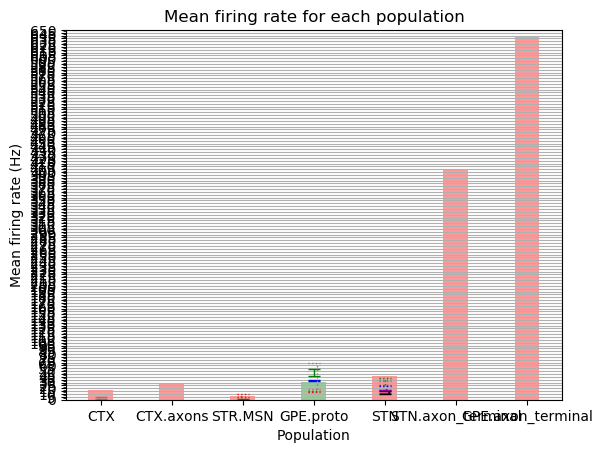

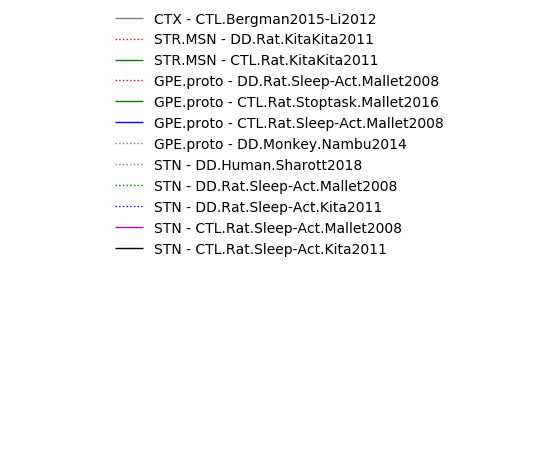

In [48]:

# Also plot target rates in DD and normal conditions
invivo_rates = { # (upper, lower) or (median-std, median+std)
    'CTX': {
        'CTL.Bergman2015-Li2012': [1.0, 5.0],
    },
    'STR.MSN': {
        'DD.Rat.KitaKita2011': [3.8, 9.4], # Kita & Kita (2011): baseline, peak is 140
        'CTL.Rat.KitaKita2011': [0.0, 1.65], # Kita Kita (2011)
    },
    'STR.FSI': {
        'CTL.Berke2004': [10.0, 100.0], # Berke (2004, 2008)
    },
    'GPE.proto': {
        'DD.Monkey.Nambu2014': [18.7, 63.7], # Nambu (2014): mean 41.2
        'CTL.Rat.Stoptask.Mallet2016': [41.3, 53.5],
        'CTL.Rat.Sleep-Act.Mallet2008': [32.4, 35.0],
        'DD.Rat.Sleep-Act.Mallet2008': [13.6, 14.6],
        # Nambu(2014): mean 65.2
    },
    'GPE.arky': {
        'CTL.Rat.Mallet2016': [7.0, 10.8], # rat, Mallet (2016)
    },
    'STN': {
        # 'CTL.Monkey.Bergman2015': [20.0, 25.0], # Bergman book
        'CTL.Rat.Sleep-Act.Mallet2008': [11.1, 16.6],
        'DD.Rat.Sleep-Act.Mallet2008': [25.8, 37.4],
        'CTL.Rat.Sleep-Act.Kita2011': [9.8, 14.8],
        'DD.Rat.Sleep-Act.Kita2011': [17.3, 23.3],
        'DD.Human.Sharott2018': [33.0, 34.0],
    }
}

fig, ax = plt.subplots()

model_pops = [k for k in pop_firing_rates.keys() if 'surrogate' not in k]
index = np.arange(len(model_pops))
bar_width = 0.35
opacity = 0.4

rate_indicators = []
rate_labels = []
for i, pop_label in enumerate(model_pops):
    # Draw in vivo rates
    for j, src_rates in enumerate(invivo_rates.get(pop_label, {}).items()):
        label, bounds = src_rates
        color = 'rgbmk'[j] if 'Rat' in label else 'grey' 
        line_kwargs = {'color': color, 'linewidth': 1.0, 'linestyle': ':' if label.startswith('DD') else '-'}
        lines = ax.vlines(i-.02+j*.02, bounds[0], bounds[1], **line_kwargs)
        ax.hlines(bounds, i-bar_width/4, i+bar_width/4, **line_kwargs)
        rate_indicators.append(lines)
        rate_labels.append('{} - {}'.format(pop_label, label))
    
    # Draw simulation rates
    pop_rate = pop_firing_rates[pop_label]
    color = 'green' if (bounds[0] <= pop_rate <= bounds[1]) else 'red' # red bar if not within in-vivo range
    ax.bar(i, pop_rate, bar_width, alpha=opacity, color=color)


ax.set_xlabel('Population')
ax.set_ylabel('Mean firing rate (Hz)')
ax.set_title('Mean firing rate for each population')
ax.set_xticks(index)
ax.set_xticklabels(model_pops)
max_rate = max(pop_firing_rates.values())+10
ax.set_yticks(np.arange(0, max_rate+5, 5), minor=False)
ax.set_yticks(np.arange(0, max_rate+2.5, 2.5), minor=True)
ax.set_ylim((0, max_rate))
ax.grid(True, axis='y', which='major')
# ax.legend()

# Draw separate legend
fig, ax = plt.subplots()
fig.legend(rate_indicators, rate_labels, loc='upper center', frameon=False)
ax.axis('off')

## Running Spikerates

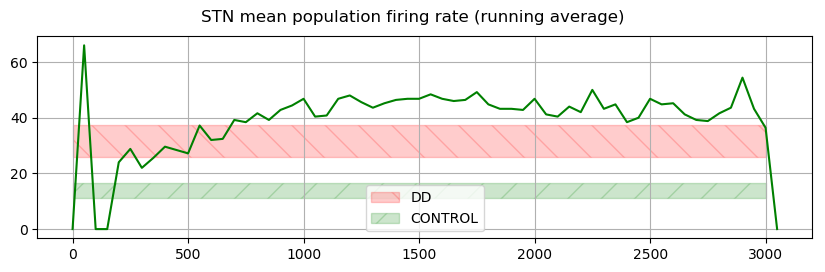

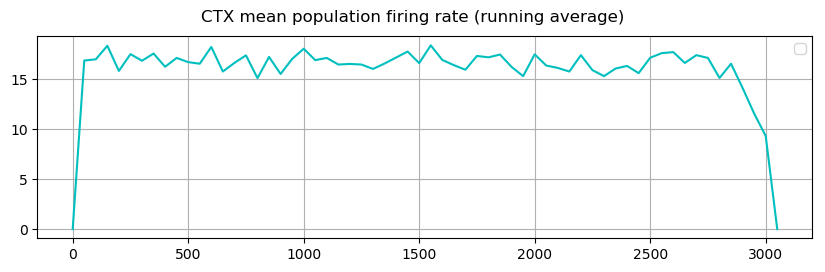

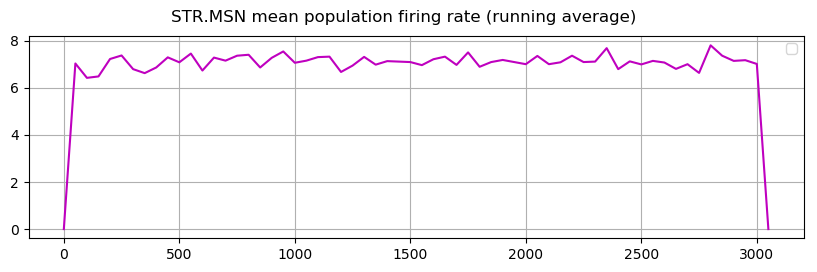

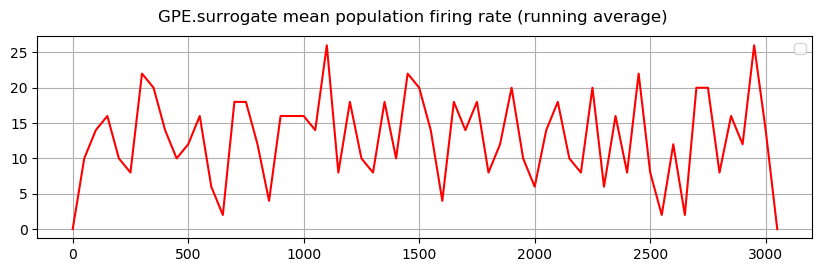

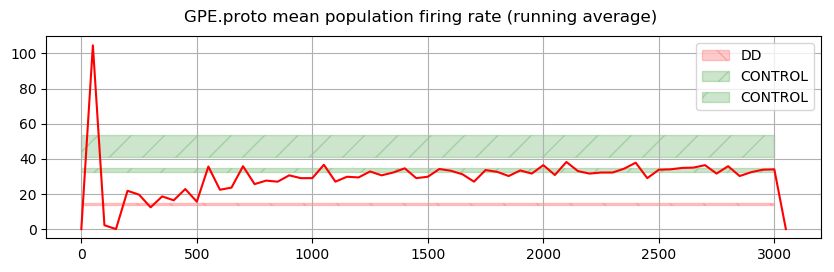

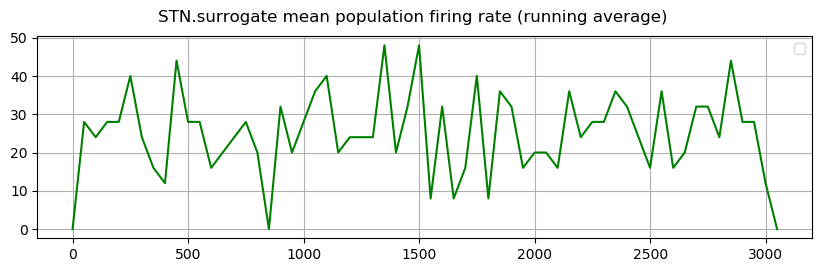

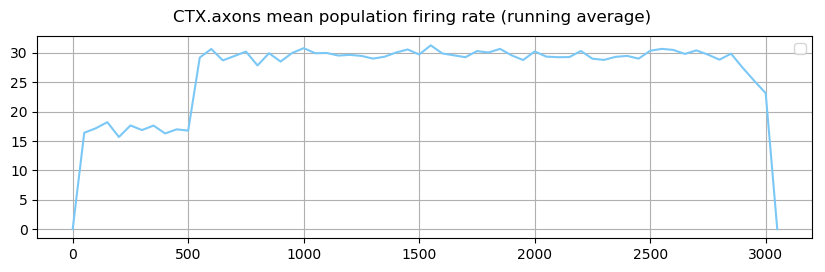

In [49]:
# %%skip False

def plot_avg_spikerate(pop_label, cell_ids=None, t_range=None, bin_width=20.0, adaptive=False, fig=None):
    """
    Plot running mean firing rate of population.
    Bin width also determines bin spacing (no sliding window).
    """
    segment = pops_segments[pop_label]
    if cell_ids is None:
        cell_ids = range(len(segment.spiketrains))
    if t_range is None:
        t_range = (0.0, np.round(segment.spiketrains[0].t_stop.magnitude, 3))
    
    min_spikes = 10
    # Adaptive method increases bin adaptively until 'min_spikes' included
    if adaptive:
        mean_rates = ephys_algos.nrn_avg_rate_adaptive([segment.spiketrains[i] for i in cell_ids],
                                                      t_range[0], t_range[1], binwidth=bin_width,
                                                      minsum=min_spikes).as_numpy()
    else:
        mean_rates = ephys_algos.nrn_avg_rate_simple([segment.spiketrains[i] for i in cell_ids],
                                                    t_range[0], t_range[1],
                                                    binwidth=bin_width).as_numpy()
    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(page_width,ax_height))
    else:
        nrows = len(fig.axes)+1
        ax = fig.add_subplot(nrows,1,nrows)
        
    # Add in-vivo rate bounds
    for j, src_rates in enumerate(invivo_rates.get(pop_label, {}).items()):
        label, bounds = src_rates
        if 'Mallet' not in label:
            continue
        color = 'red' if 'DD' in label else 'green'
        hatch = '\\' if 'DD' in label else '/'
        hatch_label = 'DD' if 'DD' in label else 'CONTROL'
        line_kwargs = {'color': color, 'alpha': 0.2, 'linewidth': 1.0, 
                       'hatch': hatch,  'label': hatch_label}
        ax.fill_between(np.linspace(t_range[0], t_range[1], 10),
                        bounds[0], bounds[1], **line_kwargs)
        
    t_axis = np.arange(mean_rates.size) * bin_width + t_range[0]
    ax.plot(t_axis, mean_rates, color=get_pop_color(pop_label))
    ax.legend()
    ax.grid(True)
    
    fig.suptitle('{} mean population firing rate (running average)'.format(pop_label))
    return fig, ax

for pop in pop_labels:
    plot_avg_spikerate(pop, bin_width=50)
#fig.tight_layout()

## Somatic Rastergrams

Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31/rastergram_CTX_cell-0-19.pdf
Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31/rastergram_CTX.axons_cell-0-19.pdf
Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31/rastergram_STR.MSN_cell-0-19.pdf
Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s

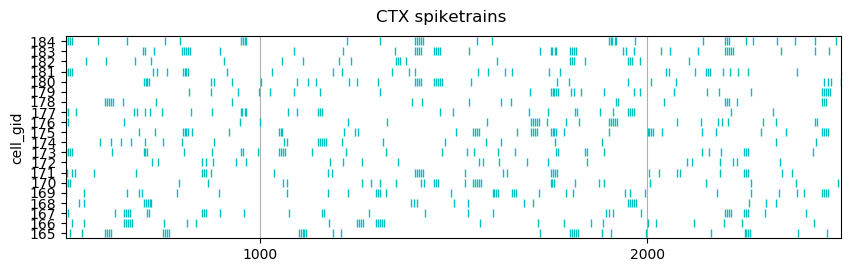

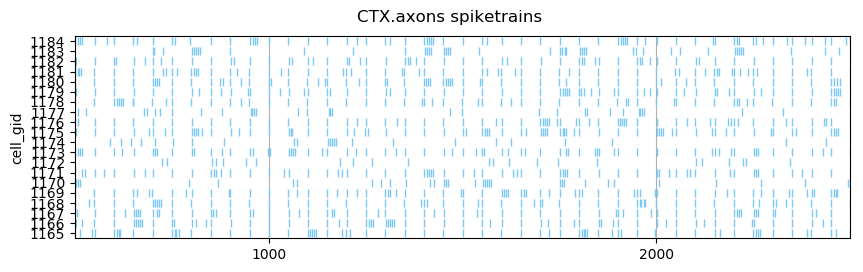

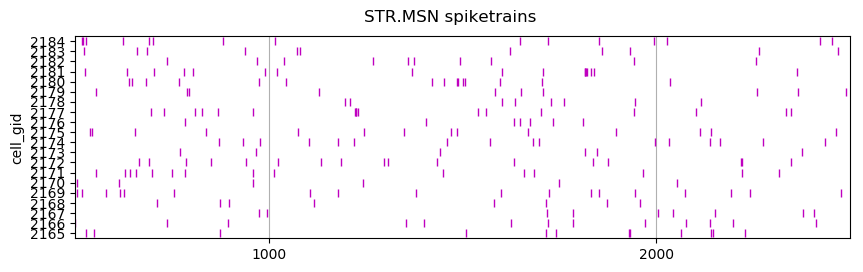

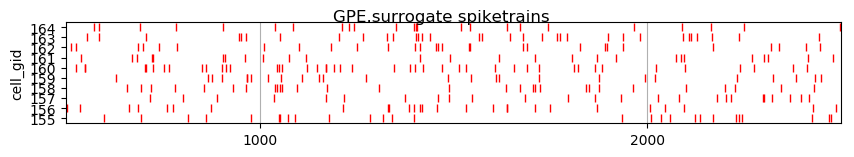

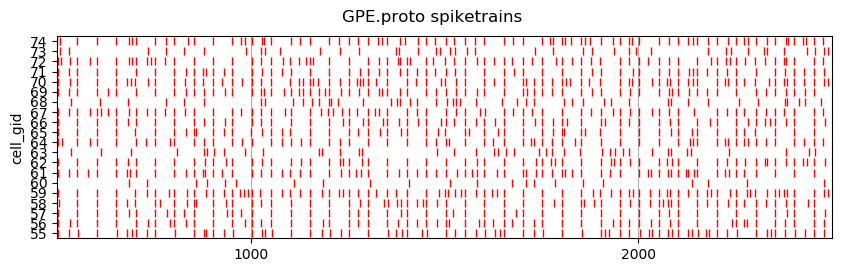

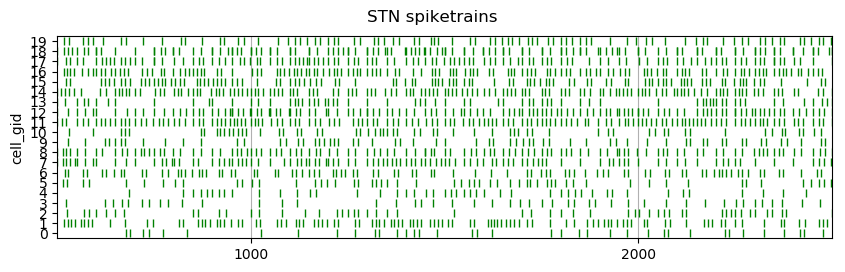

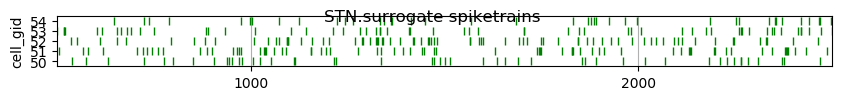

In [50]:
# Choose populations and cells indices to plot
shared_axis = None
for pop_label in sorted(pop_labels, key=get_pop_order):
    segment = pops_segments[pop_label]
    max_num_plot = 20
    num_spiketrains = min(len(segment.spiketrains), max_num_plot)
    # SETPARAM: choose cells to plot
    cell_indices = (0 + np.arange(num_spiketrains, dtype=int)) % len(segment.spiketrains)
    t_interval = [ROI_INTERVAL[0] - 500, ROI_INTERVAL[0] + 1500.0] # SETPARAM: time interval
    fig_height = ax_height*num_spiketrains/20.0
    # NOTE: don't use sharey when different population sizes
    spike_trains = pops_segments[pop_label].spiketrains
    fig, shared_axis = plot_spiketrain(spike_trains, cell_indices, t_interval, export=True,
                                       pop_label=pop_label, sharex=shared_axis, sharey=None,
                                       figsize=(page_width, fig_height), y_labels='cell_gid',
                                       sort_by='cell_gid')

# plot_spiketrain('STN', range(20), (0.0, 5e3))

## Axonal Rastergrams

Get spike times from recorded voltages in axons.

Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31/rastergram_STN.axon_terminal_cell-0-19.pdf
Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31/rastergram_GPE.axon_terminal_cell-0-19.pdf
Figure saved to file /home/luye/Documents/simdata/simdata_newsonic/sweeps_dbs-phase/stim-all_conf-V2/LuNetDBS_2019.08.07_18.54.55_job-13295_axons-full-V2_dbs-phase-000/analysis/figures_MANUAL-analysis_1.0s-3.0s_2020.01.09-11.47.31/rastergram_CTX.axons_cell-0-19.pdf


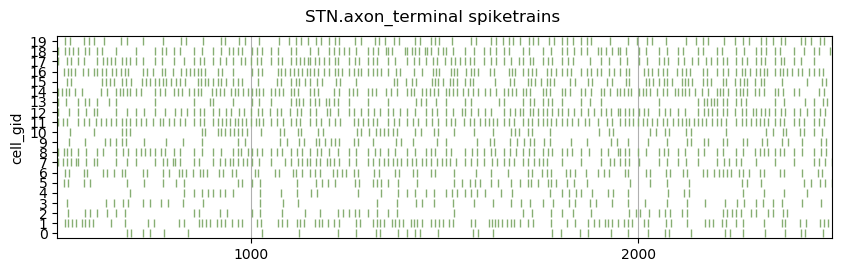

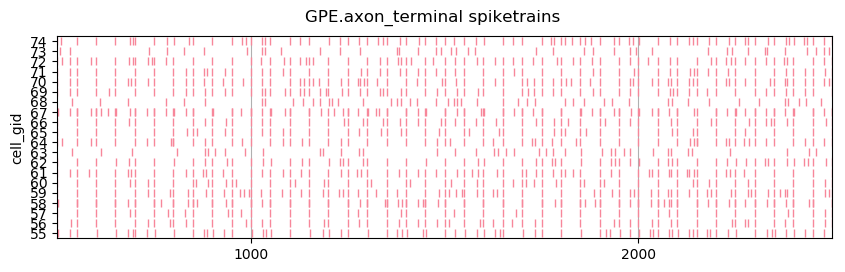

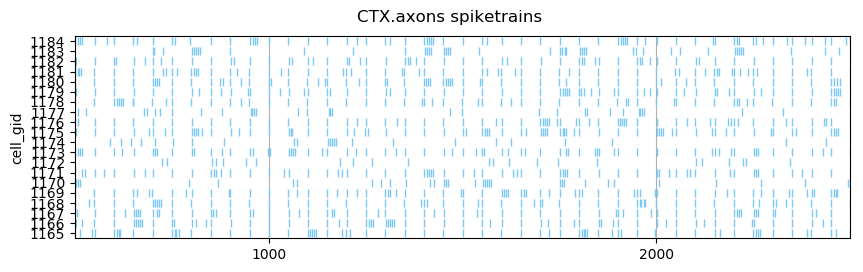

In [51]:
# Choose populations and cells indices to plot
shared_axis = None
for pop_label in ('STN.axon_terminal', 'GPE.axon_terminal', 'CTX.axons'):
    spike_trains = all_spiketrains[pop_label]
    max_num_plot = 20
    num_spiketrains = min(len(spike_trains), max_num_plot)
    # SETPARAM: choose cells to plot
    cell_indices = (0 + np.arange(num_spiketrains, dtype=int)) % len(spike_trains)
    # t_interval = [ROI_INTERVAL[0] + 500, ROI_INTERVAL[0] + 2500.0] # SETPARAM: time interval
    fig_height = ax_height * num_spiketrains / 20.0
    # NOTE: don't use sharey when different population sizes
    fig, shared_axis = plot_spiketrain(spike_trains, cell_indices, t_interval, export=True,
                                       pop_label=pop_label, sharex=shared_axis, sharey=None,
                                       figsize=(page_width, fig_height), y_labels='cell_gid',
                                       sort_by='cell_gid')

# Activation DBS

## Functions

In [ ]:
def calc_psth_triggered(spike_trains, bins=None, bin_width=None):
    """
    PSTH triggered on DBS onset times
    """
    # Calculate bins from bin width
    if bin_width:
        bins = np.arange(0, (dbs_IPI // 0.25 + 1) * 0.25, 0.25)
    else:
        bins = np.linspace(0, dbs_IPI, bins)
    
    spike_arrays = [st.as_array() for st in spike_trains]
    counts_sum, counts_all, bin_edges = ephys_algos.numpy_psth_triggered(spike_arrays, dbs_onset_times, bins=bins)
    return counts_sum, counts_all, bin_edges

    
def plot_psth_triggered(counts_sum, bin_edges, pop_label=None, compare_spike_trains=None,
                        stimlock_window=None, plot_cdf=True, fractions=True, ylim=None,
                        export=False):
    """
    Histogram plot of stimulus-locked spike fractions in population.
    """
    if stimlock_window is None:
        stimlock_window = all_stimlock_windows[pop_label]
    bin_scale = 100.0 if fractions else 1
    
    bin_counts = counts_sum.astype(float)
    bin_fractions = bin_counts / np.sum(counts_sum)
    bin_values = bin_fractions if fractions else bin_counts
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = np.diff(bin_edges)[0]
    
    # Stimulus-locked spikes
    stimlock_mask = (bin_edges >= stimlock_window[0]) & (bin_edges < stimlock_window[1])
    stimlock_mask = stimlock_mask[:-1]
    stimlock_fraction = np.sum(bin_fractions[stimlock_mask])
    print("{} : fraction stimulus-locked spikes ([{}, {}] ms) = {}".format(
            pop_label, stimlock_window[0], stimlock_window[1], stimlock_fraction))
    
    # Plot PSTH
    fig, ax = plt.subplots(figsize=(page_width*0.6, 3.0))
    if compare_spike_trains is not None:
        # Sampling colors from linear scale:
        cmap = plt.get_cmap('Oranges')
        bar_colors = [cmap(x) for x in np.linspace(0.33, 1, len(compare_spike_trains) + 1)]
        
        for i, spk_label in enumerate(compare_spike_trains.keys()):
            spike_trains = compare_spike_trains[spk_label]
            spike_arrays = [st.as_array() for st in spike_trains]
            
            bin_counts_cmp, _, _ = ephys_algos.numpy_psth_triggered(spike_arrays, dbs_onset_times, bins=bin_edges)
            bin_fractions_cmp = bin_counts_cmp.astype(float) / np.sum(bin_counts_cmp)
            bin_values_cmp = bin_fractions_cmp if fractions else bin_counts_cmp
            
            ax.bar(bin_centers, bin_values_cmp * bin_scale, width=bin_width,
                   edgecolor=None, color=bar_colors[i], alpha=1.0, label=spk_label)
            alpha = 0.7
        
        bar_color = bar_colors[-1]
    
    else:
        alpha = 1.0
        bar_color = 'xkcd:orange'

    ax.bar(bin_centers, bin_values * bin_scale, width=bin_width, label=pop_label,
           edgecolor=None, color=bar_color, alpha=alpha)
    
    ax.set_title('DBS PSTH ({})'.format(pop_label))
    ax.set_ylabel('spikes (%)' if fractions else 'spikes (total)')
    ax.set_xlabel('$t_{spk} - t_{DBS,i}$ (ms)')
    if ylim is not None:
        ax.set_ylim(ylim)
    if compare_spiketrains is not None:
        ax.legend()
    ax.grid(True, axis='both', which='both')
    
    # Plot stimulus-locked CDF
    if plot_cdf:
        cdf_stimlock = np.append([0.0], np.cumsum(bin_fractions))
        cdf_xvalues = bin_edges
        ax_r = ax.twinx()
        ax_r.plot(cdf_xvalues, cdf_stimlock, color='k')
        ax_r.set_ylabel('Cumulative sum')
        ax_r.set_ylim((0, 1))
    
    fig.subplots_adjust(bottom=0.15) # prevent clipping of xlabel
    
    # Save figure
    if _data.export_figs and export:
        fname = 'PSTH-{}_dbs-triggered_{}-'.format('percent' if fractions else 'absolute', pop_label)
        if compare_spike_trains:
            fname += '-'.join([p for p in compare_spike_trains.keys()])
        save_figure(fname, fig=fig, bbox_inches='tight')
    return fig, ax

## Somatic Activation

In [ ]:
# Activation of STN soma
spike_trains = pops_segments['STN'].spiketrains
spk_label = 'STN'
all_stimlock_windows[spk_label] = (0.0, 1.75)

# Activation fractions
cells_activation = calc_train_stimlock_fractions(
                        spike_trains, dbs_onset_times)

cells_gids = [st.annotations['source_id'] for st in spike_trains]
cells_gids_acts = dict(zip(cells_gids, cells_activation))

# Activation bar chart
plot_stimlock_fractions(cells_activation, pop_label=spk_label)

# PSTH
counts_sum, _, bin_edges = calc_psth_triggered(spike_trains, bin_width=0.2)
plot_psth_triggered(counts_sum, bin_edges, pop_label=spk_label)

# save data
all_spiketrain_stimlock[spk_label] = cells_gids_acts
all_psth_dbs[spk_label] = (counts_sum, bin_edges)

In [ ]:
# Activation of GPe soma
spike_trains = pops_segments['GPE.proto'].spiketrains
spk_label = 'GPE.proto'
all_stimlock_windows[spk_label] = (1.75, 2.75)


# Activation fractions
cells_activation = calc_train_stimlock_fractions(
                        spike_trains, dbs_onset_times)

cells_gids = [st.annotations['source_id'] for st in spike_trains]
cells_gids_acts = dict(zip(cells_gids, cells_activation))

# Activation bar chart
plot_stimlock_fractions(cells_activation, pop_label=spk_label)


# PSTH
counts_sum, _, bin_edges = calc_psth_triggered(spike_trains, bin_width=0.2)
plot_psth_triggered(counts_sum, bin_edges, pop_label=spk_label)

# save data
all_spiketrain_stimlock[spk_label] = cells_gids_acts
all_psth_dbs[spk_label] = (counts_sum, bin_edges)

## Axonal Activation

**STN axons**

In [ ]:
spk_label = 'STN.axon_terminal'
spike_trains = all_spiketrains[spk_label]
all_stimlock_windows[spk_label] = (2.0, 3.0)

# Percent pulses with stimulus-locked spikes
cells_activation = calc_train_stimlock_fractions(
                        spike_trains, dbs_onset_times)

cells_gids = [st.annotations['source_id'] for st in spike_trains]
cells_gids_acts = dict(zip(cells_gids, cells_activation))

# Activation bar chart
plot_stimlock_fractions(cells_activation, pop_label=spk_label)


# PSTH
counts_sum, _, bin_edges = calc_psth_triggered(spike_trains, bin_width=0.2)
compare_spike_trains = {p: all_spiketrains[p] for p in ('STN', 'STN.axon_midpoint') if p in all_spiketrains}
plot_psth_triggered(counts_sum, bin_edges, pop_label=spk_label,
                    compare_spike_trains=compare_spike_trains,
                    fractions=True, ylim=None, export=True)

# NOTE: disable fractions and set y-limits for comparison between simulations

# save data
all_spiketrain_stimlock[spk_label] = cells_gids_acts
all_psth_dbs[spk_label] = (counts_sum, bin_edges)

In [ ]:
# Propagation delay and transmission reliability
# trains_a = sorted(all_spiketrains['STN'],
#                   key=lambda t:t.annotations['source_id'])

# trains_b = sorted(all_spiketrains['STN.axon_terminal'],
#                   key=lambda t:t.annotations['source_id'])

# compare_spiketrains(trains_a, trains_b, (2000, 2300), range(10))
# plot_propagation_delays(trains_a, trains_b, bin_width=0.1)

**GPe axons**

In [ ]:
spk_label = 'GPE.axon_terminal'
spike_trains = all_spiketrains[spk_label]
all_stimlock_windows[spk_label] = (0.0, 1.0)

# Percent pulses with stimulus-locked spikes
cells_activation = calc_train_stimlock_fractions(
                        spike_trains, dbs_onset_times)

cells_gids = [st.annotations['source_id'] for st in spike_trains]
cells_gids_acts = dict(zip(cells_gids, cells_activation))

# Activation bar chart
plot_stimlock_fractions(cells_activation, pop_label=spk_label)


# PSTH
counts_sum, _, bin_edges = calc_psth_triggered(spike_trains, bin_width=0.2)
compare_spike_trains = {p: all_spiketrains[p] for p in ('GPE.proto', 'GPE.axon_midpoint') if p in all_spiketrains}
plot_psth_triggered(counts_sum, bin_edges, pop_label=spk_label,
                    compare_spike_trains=compare_spike_trains,
                    fractions=True, ylim=None, export=True)

# save data
all_spiketrain_stimlock[spk_label] = cells_gids_acts
all_psth_dbs[spk_label] = (counts_sum, bin_edges)

In [ ]:
# Propagation delay and transmission reliability
# trains_a = sorted(all_spiketrains['GPE.proto'],
#                   key=lambda t:t.annotations['source_id'])

# trains_b = sorted(all_spiketrains['GPE.proto.axon_terminal'],
#                   key=lambda t:t.annotations['source_id'])

# compare_spiketrains(trains_a, trains_b, (2000, 2300), range(10))
# plot_propagation_delays(trains_a, trains_b, bin_width=0.1)

**CTX axons**

In [ ]:
# These are _all_ 1000 spiketrains recorded during simulation
spk_label = 'CTX.axons'
spike_trains = all_spiketrains[spk_label]
all_stimlock_windows[spk_label] = (0.0, 2.0)

# Percent pulses with stimulus-locked spikes
cells_activation = calc_train_stimlock_fractions(
                        spike_trains, dbs_onset_times)

cells_gids = [st.annotations['source_id'] for st in spike_trains]
cells_gids_acts = dict(zip(cells_gids, cells_activation))

# Activation bar chart
plot_stimlock_fractions(cells_activation, pop_label=spk_label)


# PSTH
counts_sum, _, bin_edges = calc_psth_triggered(spike_trains, bin_width=0.2)
compare_spike_trains = {p: all_spiketrains[p] for p in ('CTX',)}
plot_psth_triggered(counts_sum, bin_edges, pop_label=spk_label,
                    compare_spike_trains=compare_spike_trains,
                    fractions=True, ylim=None, export=True)

# save data
all_spiketrain_stimlock[spk_label] = cells_gids_acts
all_psth_dbs[spk_label] = (counts_sum, bin_edges)

## Soma vs Axon

In [ ]:
spk_label_pairs = [('STN', 'STN.axon_terminal'), ('GPE.proto', 'GPE.axon_terminal')]

    
# Calculate data for bar charts
x = np.arange(len(spk_label_pairs))  # the label locations
calc_pop_act = lambda acts: sum((1.0 for a in acts if a >= 0.8)) / len(acts)
act_soma = [calc_pop_act(all_spiketrain_stimlock[k[0]].values()) for k in spk_label_pairs]
act_axon = [calc_pop_act(all_spiketrain_stimlock[k[1]].values()) for k in spk_label_pairs]

# Draw the bars
fig, ax = plt.subplots(figsize=(.75*fig_width, 0.5*.75*fig_width))

bars_l = ax.bar(x - bar_width/2, act_soma, width=bar_width, label='soma',
                  color=style_color_cycle[0], alpha=0.5, edgecolor=None)

bars_r = ax.bar(x + bar_width/2, act_axon, width=bar_width, label='axon terminal',
                  color=style_color_cycle[1], alpha=0.5, edgecolor=None)

# Axis decoration
ax.set_ylabel('Activation fraction')
ax.set_title('Activation: soma vs axon')
ax.set_ylim((0, 1))
ax.set_xticks(x)
ax.set_xticklabels([labels[0].split('.')[0] for labels in spk_label_pairs])
ax.grid(True, axis='y')
ax.legend()

if not automatic_execution:
    save_figure('activation-bars_soma-vs-axon',fig=fig)

## Compare other sim

In [ ]:
# Compare activation with other simulation
# if not automatic_execution:

#     # Load data from other simulation (stim only STN, only GPE)
#     # fdata = '/home/luye/Documents/sim_data/LuNetDBS/simdata_newsonic/sweeps_stim-selective/sweep_dbs-amp_conf-V6_stim-only-stn_wsyn-0/LuNetDBS_2019.09.03_11.04.34_job-44575_netconf-V6_dbs-amp-0.8_stim-only-stn_wsyn-axterm-0/analysis/analysis_results_1.0s-4.0s_09.04_MANUAL.pkl'
#     fdata = '/home/luye/Documents/sim_data/LuNetDBS/simdata_newsonic/sweeps_stim-selective/sweep_dbs-amp_conf-V6_stim-only-gpe_wsyn-0/LuNetDBS_2019.09.03_11.04.39_job-44574_netconf-V6_dbs-amp-0.8_stim-only-gpe_wsyn-axterm-0/analysis/analysis_results_1.0s-4.0s_09.04_MANUAL.pkl'
#     with open(fdata, 'rb') as f:
#         other_analysis_data = pickle.load(f)
#     other_sim_stimlock = other_analysis_data['stimlocked_spikes_dbs']

#     # Calculate data for bar charts
#     pop_label = 'GPE' # STN
#     spk_labels = ('GPE.proto', 'GPE.axon_terminal')
#     ax_labels = ('soma', 'axon terminal')
#     x = np.arange(len(spk_labels))  # the label locations
#     calc_pop_act = lambda acts: sum((1.0 for a in acts if a >= 0.8)) / len(acts)

#     act_sim_this = [calc_pop_act(all_spiketrain_stimlock[k].values()) for k in spk_labels]
#     act_sim_other = [calc_pop_act(other_sim_stimlock[k]) for k in spk_labels]

#     # Draw the bars
#     fig, ax = plt.subplots(figsize=(.75*fig_width, .5*.75*fig_width))

#     bars_l = ax.bar(x - bar_width/2, act_sim_this, width=bar_width, label='connected',
#                       color=style_color_cycle[0], alpha=0.5, edgecolor=None)

#     bars_r = ax.bar(x + bar_width/2, act_sim_other, width=bar_width, label='disconnected',
#                       color=style_color_cycle[1], alpha=0.5, edgecolor=None)

#     # Axis decoration
#     ax.set_ylabel('Activation fraction')
#     ax.set_ylim((0, 0.8))
#     ax.set_xticks(x)
#     ax.set_xticklabels(ax_labels)
#     ax.grid(True, axis='y')
#     ax.legend()

#     save_figure('activation-{}_vs-disconnected-w0'.format(pop_label),fig=fig)

#     del other_analysis_data

## SEP vs act func

SEP amplitude by cell GID. Can plot this vs somatic activating function, electrode distance, etc.

In [ ]:
SEP_amplitudes = {} # sig_label : str -> gid_amps : dict[gid: int -> np.array[float]]
act_somatic = {'STN': {}, 'GPE': {}} # gid : int -> acts : list[float]
act_axonal = {'STN': {}, 'GPE': {}}
dist_axonal = {'STN': {}, 'GPE': {}}

# Load activating function values
comp_data_fpath = '/home/luye/Documents/sim_data/LuNetDBS/simdata_newsonic/sweeps_dbs-amp/sweep_dbs-amp_conf-V6_rec-axmid-EI/LuNetDBS_2019.09.03_16.31.28_job-44728_netconf-V6_rec-axmid-EI_dbs-amp-0.8/comp-locs_with-act-fun/comp-locs_STN_space-dwi_scale-um.pkl'
try:
    with open(comp_data_fpath, 'rb') as f:
        comp_data = pickle.load(f)
    loaded_act_data = True
except IOError:
    loaded_act_data = False

if not automatic_execution:
    
    # Get somatic Vm signal
    pop_label = 'STN'
    sig_label = pop_label + '_Vm'
    vm_signal = all_vm_signals[pop_label]

    # SEP amplitudes for each cell in population, by GID
    SEP_amplitudes[sig_label] = gids_SEPamps = {}

    for i_cell, gid in enumerate(vm_signal.annotations['source_ids']):
        vm_cell = vm_signal.as_array()[:, i_cell]

        Ts = vm_signal.sampling_period.magnitude
        t0 = vm_signal.t_start.magnitude
        SEP_delay = 0.05 # pulse width is 0.060 ms

        vm_indices = np.round((dbs_onset_times + SEP_delay - t0) / Ts).astype(int)
        vm_indices = vm_indices[(vm_indices >= 0) & (vm_indices < vm_signal.shape[0])]

        gids_SEPamps[gid] = vm_cell[vm_indices]
    

    # Plot for verification
    # RESULT: 0.05 ms is most accurate delay to catch the SEP peak
    fig, ax = plt.subplots(figsize=(fig_width, .5*fig_width))
    gid = 23
    ind = vm_signal.annotations['source_ids'].tolist().index(gid)
    ax.plot(vm_signal.times, vm_signal.magnitude[:, ind])
    ax.plot(vm_signal.times[vm_indices], vm_signal.magnitude[vm_indices, ind], 'r+')
    ax.set_xlim((dbs_onset_times[0], dbs_onset_times[10]))
    ax.grid()

    
if not automatic_execution and loaded_act_data:
    
    # Make data points
    x_vals = []
    y_vals = []
    for i, gid in enumerate(comp_data['gids']):
        cell_acts = comp_data['comp_act'][i]
        # Save x,y datapoint for cell
        x_vals.append(np.median(cell_acts['somatic']))
        y_vals.append(np.median(gids_SEPamps[gid]))
        # Save for later
        act_somatic['STN'][gid] = cell_acts['somatic']
        
    x = np.array(x_vals)
    y = np.array(y_vals)
        
    # Scatter plot : median activating function vs SEP amplitude
    fig, ax = plt.subplots(figsize=(fig_width, .5*fig_width))
    ax.plot(x, y, '.')
    ax.grid()
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.set_ylabel('SEP peak voltage (mV)')
    ax.set_xlabel('activating function (V/s)')
    ax.set_title('Somatic activating function ({})'.format(pop_label))
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_vals, y_vals)
    ax.plot(x, intercept + slope*x, '-', color='k', lw=.5, label='linear fit')
    ax.text(.98, .05, '$R^2$ = {:.2f}\n$p^r$ = {:f}'.format(r_value**2, p_value), 
            color='k', transform=ax.transAxes, ha='right')
    
    save_figure('SEP_regress_act-somatic', fig=fig)

## SEP vs syn-stimlock

Plot each cell as a datapoint `(x, y)` where x,y are one of:

- x1 = mean presynaptic stimlock fraction (GLU)
- x2 = mean presynaptic stimlock fraction (GABA)
- y1 = SEP amplitude
- y2 = somatic output stimlock fraction

In [ ]:
if not automatic_execution and loaded_act_data:
    
    # Population
    pop_label = 'STN'
    sig_label = 'STN_Vm'
    spk_lbl_soma = 'STN'
    spk_lbl_term = 'STN.axon_terminal'

    # SEP amplitudes for each cell in population, by GID
    gids_SEPamps = SEP_amplitudes[sig_label]

    # Get activation values for pre-synaptic cells
    labels_metrics = {
        'y1': 'SEP-amps_comp-soma',
        'y2': 'stimlock_comp-soma',
        'y3': 'stimlock_comp-term',
        'x1': 'stimlock_syn-GLU',
        'x2': 'stimlock_syn-GABA',
        'x3': 'act-func_comp-soma',
        'gid': 'cell-gid'
    }
    metrics_labels = {v: k for k,v in labels_metrics.items()}
    xy_data = {k: [] for k in labels_metrics.keys()}
    
    y1_SEPamps = []
    y2_stimlock_soma = []
    y3_stimlock_term = []
    x1_stimlock_GLU = []
    x2_stimlock_GABA = []
    for post_gid, SEPamp in gids_SEPamps.items():
        cell_data = {'gid': post_gid}
        
        # SEP amplitude and stimlock fractions
        cell_data['y1'] = np.median(SEPamp)
        cell_data['y2'] = all_spiketrain_stimlock[spk_lbl_soma][post_gid]
        cell_data['y3'] = all_spiketrain_stimlock[spk_lbl_term][post_gid]
        
        # Activation function
        cell_data['x3'] = np.median(act_somatic['STN'][post_gid])
        
        # Get presynaptic cells (GABA)
        presyn_pop_inds = get_presynaptic_pop_indices(post_gid, 'GPE.all', 'STN')
        presyn_cell_gids = [network_params['GPE.all']['gids'][i] for i in presyn_pop_inds]
        cell_data['x2'] = np.mean([all_spiketrain_stimlock['GPE.axon_terminal'][pre_gid] for pre_gid in presyn_cell_gids])
        
        # Get presynaptic cells (GLU)
        presyn_pop_inds = get_presynaptic_pop_indices(post_gid, 'CTX.axons', 'STN')
        presyn_cell_gids = [network_params['CTX.axons']['gids'][i] for i in presyn_pop_inds]
        cell_data['x1'] = np.mean([all_spiketrain_stimlock['CTX.axons'][pre_gid] for pre_gid in presyn_cell_gids])
        
        # Save data points
        for k, val in cell_data.items():
            xy_data[k].append(val)

In [ ]:
if not automatic_execution and loaded_act_data:
    
    # Choose data pairs to plot
    xy_pairs = [
        ('act-func_comp-soma', 'stimlock_comp-soma'),
        ('act-func_comp-soma', 'stimlock_comp-term'),
        ('SEP-amps_comp-soma', 'stimlock_comp-soma'),
        ('stimlock_syn-GLU', 'SEP-amps_comp-soma'),
        ('stimlock_syn-GABA', 'SEP-amps_comp-soma'),
        ('stimlock_syn-GLU', 'stimlock_comp-soma'),
        ('stimlock_syn-GABA', 'stimlock_comp-soma'),
        ('stimlock_comp-soma', 'stimlock_comp-term')
    ]
    
    for x_metric, y_metric in xy_pairs:
        x_vals = xy_data[metrics_labels[x_metric]]
        y_vals = xy_data[metrics_labels[y_metric]]
        x = np.asarray(x_vals)
        y = np.asarray(y_vals)
        
        # Scatter plot : median activating function vs SEP amplitude
        fig, ax = plt.subplots(figsize=(.8*fig_width, .4*fig_width))
        
        ax.plot(x_vals, y_vals, '.')
        ax.grid()
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

        labels = 'SEP peak voltage (mV)', 'stimulus-locking fraction'
        ax.set_ylabel(y_metric)
        ax.set_xlabel(x_metric)
        ax.set_title('{} vs {}'.format(x_metric, y_metric))

        # Linear regression
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_vals, y_vals)
        p_fmt = '{:.6f}' if p_value >= 1e-6 else '{:.2e}'
        ax.plot(x, intercept + slope*x, '-', color='k', lw=.5, label='linear fit')
        ax.text(.98, .05, ('$R^2$ = {:.2f}\n$p^r$ = ' + p_fmt).format(r_value**2, p_value), 
                color='k', transform=ax.transAxes, ha='right')

        save_figure('regress_{}_vs_{}'.format(x_metric, y_metric), fig=fig)

# Synaptic Conductances


In [ ]:
# TODO: STN cells with activated CTX:GPe afferents
# - save 'activation' and spikerate by GID
# - look in network matrix to find presynaptic GIDS
# - find target cells with high activation

## STN gsyn

In [ ]:
synaptic_tracenames = 'g_AMPA', 'g_NR2A', 'g_NR2BD', 'gGABAA', 'gGABAB'
segment = pops_segments['STN']
extra_sigs = ['Vm']
extra_plot_with = lambda trace_name: trace_name.startswith('g')
interval = [ROI_INTERVAL[0] + 750.0, ROI_INTERVAL[0] + 1500.0]

plot_synapse_traces('STN', max_ncell=3, max_nsyn=3,
                    trace_names=synaptic_tracenames, # add traces you want to plot
                    interval=interval, interval_only=True, beta_phase=False,
                    vm_plot_with=extra_plot_with)

# TODO: for each plotted cell, make rastergram of presynaptic spikes with colors by pre-synaptic pop

### ARTICLE

In [ ]:
# ARTICLE - STN conductance traces
synaptic_tracenames = 'g_AMPA', 'gGABAA', 'gGABAB'
segment = pops_segments['STN']
extra_sigs = ['Vm']
extra_plot_with = lambda trace_name: trace_name.startswith('g')
interval = [ROI_INTERVAL[0] + 750.0, ROI_INTERVAL[0] + 1500.0]

# NOTE: gGABAB<X> -> X denotes the synapse number
plot_synapse_traces('STN', max_ncell=5, max_nsyn=5,
                    trace_names=synaptic_tracenames, # add traces you want to plot
                    interval=interval, interval_only=True, beta_phase=False,
                    vm_plot_with=extra_plot_with, export=True)

## GPE gsyn

In [ ]:
synaptic_tracenames = 'gAMPA', 'gGABAA', 'gGABAB' # 'gNMDA' not used
segment = pops_segments['GPE.proto']
extra_sigs = ['Vm']
extra_plot_with = lambda trace_name: trace_name.startswith('g')

plot_synapse_traces('GPE.proto', max_ncell=3, max_nsyn=3,
                    trace_names=synaptic_tracenames, # add traces you want to plot
                    interval=interval, interval_only=True, beta_phase=False,
                    vm_plot_with=extra_plot_with)

# TODO: for each plotted cell, make rastergram of presynaptic spikes with colors by pre-synaptic pop

# Power Spectra

## PSD

In [ ]:
def plot_psd(freqs, psd_avg, pop_label, f_max=200.0, with_absolute_y=True):
    """
    Plots PSD on relative and absolute axis for comparison with others.
    """
    fig, ax = plt.subplots(figsize=(page_width*0.5, ax_height))
    ax.plot(freqs, psd_avg, label='{} Vm'.format(pop_label))

    ax.set_ylabel('Power ({})'.format(psd_avg.units.dimensionality))
    ax.set_xlabel('frequency ({})'.format(freqs.units.dimensionality))
    ax.set_xlim((0, f_max))
    ax.grid(True)
    ax.set_title('Welch PSD for mean {} Vm'.format(pop_label))
    # ax.set_yscale('log')
    # ax.legend(loc='best')

    if with_absolute_y:
        # PSD on shared scale for comparison with other simulations
        fig, ax = plt.subplots(figsize=(page_width*0.5, ax_height))
        ax.plot(freqs, psd_avg, label='{} Vm'.format(pop_label))
        ax.set_ylabel('Power ({})'.format(psd_avg.units.dimensionality))
        ax.set_xlabel('frequency ({})'.format(freqs.units.dimensionality))
        ax.set_xlim((0, f_max))
        ax.set_ylim((0, 10))
        ax.grid(True)
        ax.set_title('Welch PSD for mean {} Vm (absolute y-axis)'.format(pop_label))

### STN Vm

In [ ]:
pop_label = 'STN'

# Mean of Vm PSDs
freqs, psd_avg = calc_psd(pop_label, interval=ROI_INTERVAL)
plot_psd(freqs, psd_avg, pop_label)

# PSD of lfp contribution
if WITH_LFP:
    freqs, psd_avg = calc_psd(pop_label, vm_sig=all_lfp_signals[pop_label],
                              interval=ROI_INTERVAL)

    plot_psd(freqs, psd_avg, pop_label, with_absolute_y=False)

### GPE.proto

In [ ]:
pop_label = 'GPE.proto'
# segment = pops_segments[pop_label]

freqs, psd_avg = calc_psd(pop_label, interval=ROI_INTERVAL)
plot_psd(freqs, psd_avg, pop_label)

# PSD of lfp contribution
if WITH_LFP:
    freqs, psd_avg = calc_psd(pop_label, vm_sig=all_lfp_signals[pop_label],
                              interval=ROI_INTERVAL)

    plot_psd(freqs, psd_avg, pop_label, with_absolute_y=False)

### CTX spikes

In [ ]:
ctx_vm_signal.as_array().shape

In [ ]:
pop_label = 'CTX'
# segment = pops_segments[pop_label]

freqs, psd_avg = calc_psd(pop_label, vm_sig=ctx_vm_signal, interval=ROI_INTERVAL)

plot_psd(freqs, psd_avg, pop_label)

### LFP signal

In [ ]:
if WITH_LFP:
    pop_label = 'LFP.all'
    psd_ival = [ROI_INTERVAL[0] + 250, ROI_INTERVAL[1]]

    freqs, psd_avg = calc_psd(pop_label, vm_sig=lfp_signal_total,
                              interval=psd_ival)

    plot_psd(freqs, psd_avg, pop_label, with_absolute_y=False)

## Spectrogram (STFT)

In [ ]:
def plot_spectrogram(freqs, t, Sxx, pop_label, f_max=100.0, P_max=None):
    # Spectrogram 1
    fig, ax = plt.subplots(figsize=(0.75*page_width, ax_height))
    # cmap = 'viridis' / 'plasma' / 'jet'
    plt.pcolormesh(t, freqs, Sxx, cmap='viridis')
    # plt.imshow(Sxx, cmap='jet', aspect='auto', vmax=abs(Sxx).max(), vmin=Sxx.min())
    plt.ylim((0, f_max))
    plt.colorbar()
    # plt.clim(0, 20)
    if P_max is None:
        Pmax_search_i0 = 0 # int(1000.0/(t[1]-t[0]))
        P_max = abs(Sxx[:, Pmax_search_i0:]).max() # discard first second
    plt.clim(0, P_max)
    plt.ylabel('frequency (Hz)')
    plt.xlabel('time (ms)')
    ax.set_title('Spectrogram of mean {} Vm ({})'.format(pop_label, _data.psd_units.dimensionality))

### STN

In [ ]:
freqs, t, Sxx = calc_spectrogram('STN', freq_res=5.0, max_avg=100, interval=ROI_INTERVAL)
plot_spectrogram(freqs, t, Sxx, 'STN', f_max=150.0)
plot_spectrogram(freqs, t, Sxx, 'STN', f_max=150.0, P_max=2000)

### GPE.proto

In [ ]:
freqs, t, Sxx = calc_spectrogram('GPE.proto', freq_res=5.0, max_avg=100, interval=ROI_INTERVAL)
plot_spectrogram(freqs, t, Sxx, 'GPE.proto', f_max=150.0)

### CTX spikes

In [ ]:
freqs, t, Sxx = calc_spectrogram('CTX', signal=ctx_vm_signal, freq_res=5.0, max_avg=100, interval=ROI_INTERVAL)
plot_spectrogram(freqs, t, Sxx, 'CTX', f_max=150.0)

### LFP signal

In [ ]:
if WITH_LFP:
    freqs, t, Sxx = calc_spectrogram('LFP.all', signal=lfp_signal_total,
                                     freq_res=5.0, max_avg=100, interval=ROI_INTERVAL)
    
    plot_spectrogram(freqs, t, Sxx, 'LFP.all', f_max=150.0)

# Burst Metrics

Sharott et al. (2014) "Activity Parameters of STN ..."
- The mean intraburst rate was positively correlated with both bradykinesia and axial scores
- the related ratio of interspike intervals below/above 10 ms was positively correlated with these symptoms and limb rigidity.

In [ ]:
v_rec = stn_vm_signal.magnitude[:,0]
t_rec = stn_vm_signal.times.magnitude
cell_indices = [0]
plot_vm_signals(stn_vm_signal, cell_indices, ROI_INTERVAL, interval_only=False)

In [ ]:
def calc_burst_metrics(neo_spiketrains, interval, pop_label=None, save=True, **burst_params):
    """
    Calculate burst metrics for all somatic voltage traces in population.
    """
    burst_metrics = []
    for neo_train in neo_spiketrains:
        spike_times = neo_train.as_array()
        mask = (spike_times >= interval[0]) & (spike_times <= interval[1])
        spike_times = spike_times[mask]
        spike_ISIs = np.diff(spike_times)
        
        bm = ephys_algos.burst_metrics_surprise(spike_ISIs, **burst_params) 
        bm['burst_rate'] = bm['num_bursts'] / (ROI_INTERVAL[1] - ROI_INTERVAL[0])
        bm['ISI_CV'] = np.std(spike_ISIs) / np.mean(spike_ISIs)
        burst_metrics.append(bm)

    if save:
        all_burst_metrics[pop_label] = burst_metrics
    
    return burst_metrics

plotted_metrics = [
    'num_bursts', 'rate', 'median_spikes_per_burst', 'median_intra_burst_frequency',
    'proportion_spikes_in_bursts'
]

import textwrap

def plot_burst_metrics(pop_label, burst_metrics, plot_metrics=plotted_metrics):
    """
    Plot burst metrics using vertical boxplots, stacked horizontally.
    """
    # plt.style.use('ggplot')
    fig, axes = plt.subplots(1, len(plotted_metrics), figsize=(page_width, 1.5*ax_height))
    metrics = burst_metrics[0].keys()
    
    for i, metric in enumerate(plotted_metrics):
        ax = axes[i]
        ax.set_title(textwrap.fill(metric,12))
        if isinstance(burst_metrics[0][metric], (float, int)):
            map_func = lambda x,y: x + [y]
        else:
            map_func = lambda x,y: x + y
        metric_vals = reduce(map_func, (cell_metrics[metric] for cell_metrics in burst_metrics), [])
        if len(metric_vals) == 0:
            # E.g. <= 1 burst per cell -> no inter-burst intervals
            ax.text(0.5, 0.5, 'N/A', size=30, color='red', transform=ax.transAxes, ha='center')
            ax.grid(False)
            ax.set_yticks([])
        else:
            bp = ax.boxplot(metric_vals, 0, 'g+')
            ax.grid(True, which='major', axis='y')
        ax.set_xticks([])
        
    # plt.style.use('default')

## STN

In [ ]:
pop_label = 'STN'

discard = 200.0
interval = [stn_vm_signal.t_start.magnitude + discard, stn_vm_signal.t_stop.magnitude]

stn_burst_metrics = calc_burst_metrics(all_spiketrains[pop_label], interval, pop_label=pop_label, save=True,
                        surprise_cutoff=3.0, min_rate_factor=1.5)

In [ ]:
plot_burst_metrics(pop_label, stn_burst_metrics)

## GPe

In [ ]:
pop_label = 'GPE.proto'
spike_trains = [st.as_array() for st in all_spiketrains[pop_label]]

gpe_burst_metrics = calc_burst_metrics(all_spiketrains[pop_label], interval, pop_label=pop_label, save=True,
                        surprise_cutoff=3.0, min_rate_factor=1.5)

In [ ]:
plot_burst_metrics(pop_label, gpe_burst_metrics)

# Phase Analysis

Phase locking to reference signal. Should only be executed if there are Beta inputs to lock onto.

## Phase Extraction (reference)

In [ ]:
# Take 10 cells within shorter time interval
PHASE_INTERVAL = ROI_INTERVAL # SETPARAM: time interval for phase analysis
islice = neoutil.make_slice(signal, PHASE_INTERVAL)

# Choose reference signal for phase extraction
# Choose intervals to analyze spike-phase locking
phase_extraction_method = reference_phase['method']
if phase_extraction_method == 'from_ctx':
    ref_pop = 'CTX'
    locking_intervals = sim_config['CTX']['spiking_pattern']['intervals'] # for calculation of vector length
elif phase_extraction_method == 'from_stn':
    ref_pop = 'STN'
    locking_intervals = [PHASE_INTERVAL]
elif phase_extraction_method == 'from_gpe':
    ref_pop = 'GPE.proto'
    locking_intervals = [PHASE_INTERVAL]
else:
    raise ValueError("Unknown method for reference phase extraction: " + phase_extraction_method)

# We hilbert transform individual traces and mean signal
signal = all_vm_signals[ref_pop]
sigmean = all_sigmean[ref_pop + '_Vm']

num_traces = min(100, signal.shape[1])
pslice = np.s_[0:num_traces]
traces_raw = signal[islice, pslice]
times = signal.times[islice]

In [ ]:
# Plot signal for reference phase extraction
fig, ax = plt.subplots(figsize=(0.75*page_width, ax_height))
ax.set_title("Reference signal for phase extraction")

plot_ival = (PHASE_INTERVAL[1]-1000, PHASE_INTERVAL[1]) # SETPARAM: plot interval
plot_slice = neoutil.make_slice(sigmean, plot_ival)

ax.plot(sigmean.times[plot_slice], sigmean[plot_slice], color='b', label='Vref = ' + sigmean.name)
# ax.plot(ctx_vm_mean.times[plot_slice], ctx_vm_mean[plot_slice], color='b', label='Vref_phi')
ax.set_ylabel('Vm (mV)')
ax.grid(True)
ax.legend()

### Filtering

Band-pass filter in frequency band where we want to measure phase differences.

In [ ]:
# Band-pass filter in frequency band where we want to measure phase differences
Fs = signal.sampling_rate.rescale('Hz').magnitude
Fn = Fs / 2. # Nyquist frequency

def get_hilbert_passband(phase_spec):
    """
    Get passband for Hilbert transform from configuration.
    """
    band_spec = phase_spec['passband']
    if isinstance(band_spec, (tuple, list)):
        hpfreq, lpfreq = band_spec
    if isinstance(band_spec, dict):
        if isinstance(band_spec['center'], (tuple, list)):
            f_band_mid = band_spec['center'][sweep_index]
        else:
            f_band_mid = band_spec['center']
        if isinstance(band_spec['width'], (tuple, list)):
            f_band_width = band_spec['width'][sweep_index]
        else:
            f_band_width = band_spec['width']
        hpfreq = f_band_mid - f_band_width / 2.0
        lpfreq = f_band_mid + f_band_width / 2.0
    return hpfreq, lpfreq

hpfreq, lpfreq = get_hilbert_passband(reference_phase)
order = 4

# NOTE: using filtfilt/sosfiltfilt, the phase shift is corrected
assert hpfreq < lpfreq
low, high = hpfreq / Fn, lpfreq / Fn
sos = scipy.signal.butter(order, [low, high], btype='bandpass', analog=False, output='sos')

# Plot filter response
w, h = scipy.signal.sosfreqz(sos, np.linspace(0, np.pi, 2**np.ceil(np.log2(Fn))))
angles = np.unwrap(np.angle(h))
fax = w * Fn / (np.pi)

fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle("Filter response (2*pi = {})".format(Fs))
ax = axes[0]
ax.plot(fax, abs(h), 'b') # 20 * np.log10(abs(h))
ax.set_ylabel('Amplitude [dB]', color='b')
ax.grid(True)

ax = axes[1] # ax2 = ax.twinx()
ax.plot(fax, angles, 'g')
ax.set_ylabel('Angle (radians)', color='g')

ax.set_xlim((0, 50))
ax.set_xlabel('Frequency [Hz]')
ax.grid(True)

In [ ]:
# Filter signal
data = np.asarray(signal)
signal_bp = signal.duplicate_with_new_array(scipy.signal.sosfiltfilt(sos, data, axis=0))
sigmean_bp = signal.duplicate_with_new_array(scipy.signal.sosfiltfilt(sos, np.asarray(sigmean), axis=0))

In [ ]:
# Subsample signals for efficiency

# Traces: subsample to preserve up to 2 x highest frequency
fmax = 1000.0 # resolution of 1 ms for phase # 2 * lpfreq
fs_old = signal.sampling_rate.rescale('Hz').magnitude 
subsample_factor = int(fs_old / (2 * fmax))
subsample_factor = min(20, subsample_factor) # don't subsample more than 20x (20.000 -> 1.000 Hz)
signal_bpss = signal_bp[::subsample_factor, :] # adjusts 'sampling period' attribute

# Adjust indices of intervals
Ts_bpss = signal_bpss.sampling_period.magnitude
islice_ss = neoutil.make_slice(signal_bpss, PHASE_INTERVAL)
times_ss = signal_bpss.times[islice_ss]

# Reference signal: subsample but with small enough time resolution to look up spike phases
ss_factor_ref = int(0.25 / signal.sampling_period.magnitude) # 0.25 ms resolution: 1/200 of 20 Hz beta
sigmean_bpss = sigmean_bp[::ss_factor_ref, :]
Ts_ref = sigmean_bpss.sampling_period.magnitude

### Hilbert Transform

In [ ]:
# Compute analytic signal - magnitude and phase
from scipy.signal import hilbert

traces_bp = signal_bpss[islice_ss, 0:num_traces]
traces_raw = signal[islice, 0:num_traces]

# Hilbert transform individual reference signals
analytic_signal = hilbert(traces_bp, axis=0)
analytic_mag = np.abs(analytic_signal)
analytic_phase = np.angle(analytic_signal)

# Hilbert transform mean reference signal
analsig_sigmean = hilbert(sigmean_bpss, axis=0)
analmag_sigmean = np.abs(analsig_sigmean)
analphase_sigmean = np.angle(analsig_sigmean)

# NOTE: phases are already wrapped
# analytic_phase = np.unwrap(np.angle(analytic_signal), axis=0) # transform angle in interval (0, 2*pi)

In [ ]:
# Check result : plot filtered signals
def plot_analytic_signal(signal, bandpass, magnitude, phase, interval):
    fig, axes = plt.subplots(3, 1, figsize=(0.75*page_width,2*ax_height), sharex=True, sharey=False)
    fig.suptitle("Vmean: Filtered & Analytic Signal")

    iplot_orig = neoutil.make_slice(signal, interval)
    iplot_phas = neoutil.make_slice(bandpass, interval)

    # Band-pass filtered trace
    ax = axes[0]
    ax.plot(signal.times[iplot_orig], signal[iplot_orig], color='b', label='Vref')
    ax.plot(bandpass.times[iplot_phas], bandpass[iplot_phas] + signal.max(), color='g', label='Vref_BP')
    ax.set_ylabel('Vm (filtered)')
    ax.grid(True)
    ax.legend()
    # ax.set_ylim((-80, 25))

    # Magnitude of analytic signal = amplitude envelope
    ax = axes[1]
    ax.plot(bandpass.times[iplot_phas], magnitude[iplot_phas], label='magnitude')
    ax.set_ylabel('|analytic| [mV]')
    ax.grid(True)

    # Phase of analytic signal
    ax = axes[2]
    ax.plot(bandpass.times[iplot_phas], phase[iplot_phas], label='phase')
    ax.grid(True)
    ax.set_ylabel('angle(analytic) [rad]')
    ax.set_xlabel('time ({})'.format(times.units))

In [ ]:
# Analytic signal of the mean reference signal
plot_ival = (PHASE_INTERVAL[1]-1000, PHASE_INTERVAL[1]) # SETPARAM: plot interval
plot_analytic_signal(sigmean, sigmean_bpss, analmag_sigmean, analphase_sigmean, plot_ival)

In [ ]:
# Analytic signal for one representative trace
tid = 1
plot_analytic_signal(traces_raw[:,tid], traces_bp[:,tid], 
                     analytic_mag[:,tid], analytic_phase[:,tid],
                     plot_ival)

## Phase Vectors

To test the degree of phase locking to the reference signal (mean CTX Vm), we compare the STN spike times to the analytic signal of the reference.

See method description Sharott et al. (2016) and (2018)

- Hilbert transform on reference signal
- for each spike of each neuron: save the phase vector at spike time (angle + magnitude of Hilbert transform)
- for mean vector length: 
    + it does not make sense to use the magnitude of the Hilbert transform since this is for the reference signal. 
    + It makes more sense to normalize each vector to length one (scale each component by vectorn norm). 
    + As described in [this nature article](https://www.nature.com/articles/srep35135#methods-and-materials): *"The circular mean of the spike phases was calculated by taking the weighted sum of the cosine and sine of the angles, finally resulting in, the mean angle and mean vector length (R) over the number of spikes"*

In [ ]:
# Normalize and sample the complex analytic signal
analsig_norm = analsig_sigmean / np.abs(analsig_sigmean)
# analsig_norm = analsig_sigmean / np.sqrt(analsig_sigmean.real**2 + analsig_sigmean.imag**2)
# analsig_norm = analsig_sigmean / np.sqrt(analsig_sigmean * analsig_sigmean.conjugate())
_data.spike_phase_vectors = spike_phase_vectors = {}

# Phase vectors are calculated using the mean reference signal
# def calc_mean_phase_vectors(...)

In [ ]:
# DBS phase vector
pop_label = 'DBS.onset'
spiketrains = [dbs_onset_spiketrain]

# Calculate neuron and population phase vectors
dbs_phase_vecs, dbs_phase_vec = calc_mean_phase_vectors(spiketrains, pop_label,
                                intervals=locking_intervals,
                                analytic_signal=analsig_norm,
                                reference_signal=sigmean_bpss)

# Show in polar plot
plot_phase_vectors(dbs_phase_vecs, dbs_phase_vec, pop_label,
                   cell_color='grey', pop_color='orange',
                   rmax=1.0, rticks=np.arange(.2,1.2,.2), export=False)

### CTX phase vectors

In [ ]:
pop_label = 'CTX'
spiketrains = pops_segments[pop_label].spiketrains # select subset of spiketrains

# Calculate neuron and population phase vectors
ctx_cell_vecs, ctx_pop_vec = calc_mean_phase_vectors(spiketrains, pop_label,
                                intervals=locking_intervals,
                                analytic_signal=analsig_norm,
                                reference_signal=sigmean_bpss)

# Show in polar plot
plot_phase_vectors(ctx_cell_vecs, ctx_pop_vec, pop_label,
                   cell_color='grey', pop_color=get_pop_color(pop_label),
                   rmax=1.0, rticks=np.arange(.2,1.2,.2), export=False)

In [ ]:
pop_label = 'CTX.axons'
spiketrains = all_spiketrains[pop_label][:] # select subset of spiketrains

# Calculate neuron and population phase vectors
axctx_cell_vecs, axctx_pop_vec = calc_mean_phase_vectors(spiketrains, pop_label,
                                intervals=locking_intervals,
                                analytic_signal=analsig_norm,
                                reference_signal=sigmean_bpss)

# Show in polar plot
plot_phase_vectors(axctx_cell_vecs, axctx_pop_vec, pop_label,
                   cell_color='grey', pop_color=get_pop_color(pop_label),
                   rmax=1.0, rticks=np.arange(.2,1.2,.2), export=False)

### MSN phase vectors

In [ ]:
pop_label = 'STR.MSN'
spiketrains = pops_segments[pop_label].spiketrains[:100] # select subset of spiketrains

# Calculate neuron and population phase vectors
msn_cell_vecs, msn_pop_vec = calc_mean_phase_vectors(spiketrains, pop_label,
                                intervals=locking_intervals,
                                analytic_signal=analsig_norm,
                                reference_signal=sigmean_bpss)

# Show in polar plot
plot_phase_vectors(msn_cell_vecs, msn_pop_vec, pop_label,
                   cell_color='grey', pop_color=get_pop_color(pop_label),
                   rmax=1.0, rticks=np.arange(.2,1.2,.2), export=False)

### STN phase vectors

In [ ]:
pop_label = 'STN'
segment = pops_segments['STN']
spiketrains = segment.spiketrains[:] # select subset of spiketrains

# Calculate neuron and population phase vectors
stn_cell_vecs, stn_pop_vec = calc_mean_phase_vectors(spiketrains, pop_label,
                                intervals=locking_intervals,
                                analytic_signal=analsig_norm,
                                reference_signal=sigmean_bpss)

# Show in polar plot
extra_args = {
    'extra_pop_vecs': [ctx_pop_vec, msn_pop_vec],
    'extra_colors': ['c', 'm'],
    'extra_labels': ['CTX', 'MSN'],
}
plot_phase_vectors(stn_cell_vecs, stn_pop_vec, pop_label, ref_vec=ctx_pop_vec,
                   cell_color='grey', pop_color=get_pop_color(pop_label),
                   rmax=1.0, rticks=np.arange(.2,1.2,.2), export=False,
                   **extra_args)

plot_phase_histogram(pop_label, ref_vec=ctx_pop_vec, num_bins=20,
                     bar_color=get_pop_color(pop_label),
                     rmax=0.2, rmax_strict=False,
                     export=True)

In [ ]:
pop_label = 'STN.axon_terminal'
spiketrains = all_spiketrains[pop_label]

# Calculate neuron and population phase vectors
axstn_cell_vecs, axstn_pop_vec = calc_mean_phase_vectors(spiketrains, pop_label,
                                intervals=locking_intervals,
                                analytic_signal=analsig_norm,
                                reference_signal=sigmean_bpss)

# Show in polar plot
extra_args = {
    'extra_pop_vecs': [ctx_pop_vec, msn_pop_vec],
    'extra_colors': ['c', 'm'],
    'extra_labels': ['CTX', 'MSN'],
}
plot_phase_vectors(axstn_cell_vecs, axstn_pop_vec, pop_label, ref_vec=ctx_pop_vec,
                   cell_color='grey', pop_color=get_pop_color(pop_label),
                   rmax=1.0, rticks=np.arange(.2,1.2,.2), export=False,
                   **extra_args)

plot_phase_histogram(pop_label, ref_vec=ctx_pop_vec, num_bins=20,
                     bar_color=get_pop_color(pop_label),
                     rmax=0.2, rmax_strict=False,
                     export=True)

### GPE phase vectors

In [ ]:
pop_label = 'GPE.proto'
spiketrains = pops_segments[pop_label].spiketrains[:] # select subset of spiketrains

# Calculate neuron and population phase vectors
gpe_cell_vecs, gpe_pop_vec = calc_mean_phase_vectors(spiketrains, pop_label,
                                intervals=locking_intervals,
                                analytic_signal=analsig_norm,
                                reference_signal=sigmean_bpss)

# Show in polar plot
extra_args = {
    'extra_pop_vecs': [dbs_phase_vec, ctx_pop_vec, stn_pop_vec],
    'extra_colors': ['orange', 'c', 'g'],
    'extra_labels': ['DBS', 'CTX', 'STN'],
}
plot_phase_vectors(gpe_cell_vecs, gpe_pop_vec, 'GPE', ref_vec=ctx_pop_vec,
                   cell_color='grey', pop_color=get_pop_color(pop_label),
                   rmax=0.8, rticks=np.arange(.2,1.2,.2), export=False,
                   **extra_args)

plot_phase_histogram(pop_label, ref_vec=ctx_pop_vec,
                     bar_color=get_pop_color(pop_label),
                     rmax=0.2, rmax_strict=False,
                     export=True)

In [ ]:
pop_label = 'GPE.axon_terminal'
spiketrains = all_spiketrains[pop_label] # select subset of spiketrains

# Calculate neuron and population phase vectors
axgpe_cell_vecs, axgpe_pop_vec = calc_mean_phase_vectors(spiketrains, pop_label,
                                intervals=locking_intervals,
                                analytic_signal=analsig_norm,
                                reference_signal=sigmean_bpss)

# Show in polar plot
extra_args = {
    'extra_pop_vecs': [dbs_phase_vec, ctx_pop_vec, stn_pop_vec, axstn_pop_vec, gpe_pop_vec],
    'extra_colors': ['orange', 'c', 'g', 'xkcd:sage', 'r'],
    'extra_labels': ['DBS', 'CTX', 'STN', 'STN_ax', 'GPE'],
}
plot_phase_vectors(axgpe_cell_vecs, axgpe_pop_vec, 'GPE_ax', ref_vec=ctx_pop_vec,
                   cell_color='grey', pop_color='xkcd:rose pink',
                   rmax=0.8, export=True,
                   **extra_args)

plot_phase_histogram(pop_label, ref_vec=ctx_pop_vec,
                     bar_color=get_pop_color(pop_label),
                     rmax=0.2, rmax_strict=False,
                     export=False)

### ARTICLE phase vectors

In [ ]:
# Show in polar plot
extra_args = {
    'extra_pop_vecs': [dbs_phase_vec, ctx_pop_vec, stn_pop_vec, axstn_pop_vec, gpe_pop_vec],
    'extra_colors': ['orange', 'c', 'g', 'xkcd:sage', 'r'],
    'extra_labels': ['DBS', 'CTX', 'STN', 'STN_ax', 'GPE'],
}
plot_phase_vectors(axgpe_cell_vecs, axgpe_pop_vec, 'GPE_ax', ref_vec=ctx_pop_vec,
                   plot_cell_vecs=False, cell_color='grey', pop_color='xkcd:rose pink',
                   rmax=0.4, rticks=np.arange(.1, .5, .1), export=True, **extra_args)

# Currents

In [ ]:
# Make trigger signal for Beta based on zero-crossings of Beta phase
try:
    # PHASE AVAILABLE AFTER HILBERT TRANSFORM COMPUTED
    phase_pos = np.array(analphase_sigmean.ravel() >= 0, dtype=float)
    phase_zero_idx = np.where(np.diff(phase_pos) == 1)[0] + 1 # zero crossings in UP direction
    phase_zero_times = sigmean_bpss.times.magnitude[phase_zero_idx] # use Hilbert transformed signal
except NameError:
    # empty variables if Hilbert not calculated
    phase_pos = None
    phase_zero_idx = None
    phase_zero_times = None

In [ ]:
# Find phase locked units
for pop in 'STN', 'GPE.proto':
    cell_phase_vecs = exported_data['cell_phase_vecs'][pop] # imaginary numbers
    vec_idx_sorted = np.argsort(np.abs(cell_phase_vecs))[::-1] # sorted by magnitude in reversed order
    cell_idx_sorted = [pops_segments[pop].spiketrains[i].annotations['source_index'] for i in vec_idx_sorted]
    cell_gid_sorted = [pops_segments[pop].spiketrains[i].annotations['source_id'] for i in vec_idx_sorted]
    
    # Check that spiketrains are sorted according to cell indices in population
    assert all((i==j for i,j in zip(vec_idx_sorted, cell_idx_sorted)))
    
    exported_data.setdefault('phaselock_ranking_source_indices', {})[pop] = cell_idx_sorted
    exported_data.setdefault('phaselock_ranking_source_ids', {})[pop] = cell_gid_sorted

## Balance EXC:INH

In [ ]:
def plot_sim_EI_ratio(cells_currents_pre, cells_currents_post, metrics=None,
                      labels=None, bar_width = 0.35, figsize=None, export=False,
                      ylim=None):
    """ Bar charts of excitatory and inhibitory synaptic currents and ratios """
    if figsize is None:
        figsize = (_data.fig_width, _data.fig_height)
    
    if metrics is None:
        metrics = 'EXC_avg_nA', 'INH_avg_nA', 'EXC:INH'
        labels = 'I_{EXC}', 'I_{INH}', 'EXC:INH'
    else:
        assert labels is not None
    
    # Calculate data for bar charts
    x = np.arange(len(metrics))  # the label locations
    pre_data = {metric: [c[metric] for c in cells_currents_pre] for metric in metrics}
    post_data = {metric: [c[metric] for c in cells_currents_post] for metric in metrics}

    # Draw the bars
    fig, ax = plt.subplots(figsize=figsize)
    
    means_pre = [np.mean(pre_data[m]) for m in metrics]
    err_pre = [np.std(pre_data[m]) for m in metrics]
    bars_pre = ax.bar(x - bar_width/2, means_pre, width=bar_width, label='pre-DBS',
                      color=style_color_cycle[0], alpha=0.5, edgecolor=None,
                      yerr=err_pre, ecolor='black', capsize=10)
    
    
    means_post = [np.mean(post_data[m]) for m in metrics]
    err_post = [np.std(post_data[m]) for m in metrics]
    bars_post = ax.bar(x + bar_width/2, means_post, width=bar_width, label='DBS',
                      color=style_color_cycle[1], alpha=0.5, edgecolor=None,
                      yerr=err_post, ecolor='black', capsize=10)
    
    # Axis decoration
    ax.set_title('Balance of synaptic excitation and inhibition')
    ax.set_ylabel('mean synaptic current (nA)')
    if ylim:
        ax.set_ylim(ylim)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(True, axis='y')
    ax.legend()
    
    # Save figure
    if _data.export_figs and export:
        fname = 'EI-ratios_pre-post-DBS'
        save_figure(fname, fig=fig)

## ARTICLE : E/I vs Activation

In [ ]:
if not automatic_execution:
    # Recorded synaptic currents per afferent, see sim_config.json
    exc_currents = {'CTX.axons': ('i_GLU',)} # 'i_NR2A',

    # Inhibitory afferent populations
    inh_currents = {'GPE.all': ('iGABA',)}

    # Number of target cells with recorded synaptic traces
    trace_spec = next((spec for spec in sim_config['STN']['traces'] if 'i_GLU{:d}' in spec['specs']))
    num_rec = trace_spec['cells']
    rec_ids = range(num_rec)

    EI_avg_pre, cells_currents_pre, report_pre = calc_exc_inh_ratio(
        'STN', exc_currents, inh_currents, rec_ids,
        interval=[1000.0, 2000.0], print_report=False)
    
    EI_avg_post, cells_currents_post, report_post = calc_exc_inh_ratio(
        'STN', exc_currents, inh_currents, rec_ids,
        interval=[2000.0, 4000.0], print_report=False)
    
    # Get EXC:INH per cell
    EI_cells_pre = [c['EXC:INH'] for c in cells_currents_pre]
    EI_cells_post = [c['EXC:INH'] for c in cells_currents_post]
    
    # Boxplot of EXC:INH ratios
    fig, ax = plt.subplots()
    glyphs = ax.boxplot([EI_cells_pre, EI_cells_post], showmeans=True, showfliers=True)
    ax.set_ylabel('EXC:INH current ratio')
    ax.set_xticklabels(['pre-DBS', 'post-DBS'])
    ax.grid(True, axis='y')
    labels_glyphs = [(k, gs[0]) for k,gs in glyphs.items() if k in ('means', 'medians')]
    labels, glyphs = zip(*labels_glyphs)
    ax.legend(glyphs, labels)
    
    # Bar chart of currents and ratios
    plot_sim_EI_ratio(cells_currents_pre, cells_currents_post, export=True,
                      figsize=(fig_width, 0.5*fig_width), ylim=(0, 1.2))
#     plot_sim_EI_ratio(cells_currents_pre, cells_currents_post,
#                       metrics=('EXC:INH',),labels=('EXC:INH',),
#                       figsize=(0.33*fig_width, ax_height), bar_width=0.1,
#                       export=False)
    
    div = '=' * 80 + '\n'
    print(div + ' PRE-DBS \n' + div + report_pre)
    print(div + ' POST-DBS \n' + div + report_post)

# Save Notebook

In [ ]:
out_dir = os.path.join(outputs, 'analysis')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [ ]:
# Export analysis results
pickle_filepath = os.path.join(out_dir, pickle_filename)
with open(pickle_filepath, 'wb') as fout:
    pickle.dump(exported_data, fout)
print("Saved analysis results to file: " + pickle_filepath)

In [ ]:
%%javascript
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});

In [ ]:
# If not automatically executed: save results here
if not automatic_execution:
    nb_name = 'lunet_dbs_analysis'
    thisfile = nb_name + '.ipynb'
    outsuffix = '{:.1f}s-{:.1f}s'.format(ROI_INTERVAL[0]/1e3, ROI_INTERVAL[1]/1e3)
    outbase = 'MANUAL-analysis_' + outsuffix + '_' + datetime.now().strftime('%Y.%m.%d-%H.%M.%S')
    outfile_html = outbase + '.html'
    outfile_full_html = os.path.join(out_dir, outfile_html)
    outfile_full_nb = os.path.join(out_dir, outbase + '.ipynb')
    # outfile = os.path.join(outputs, 'synchrony_analysis.html')
    # Export using built-in template:
    #!jupyter nbconvert --to html --template=full --output-dir=$outputs $thisfile
    # NOTE: template comes from ToC2 Notebook Extension
    # NOTE: the class <tocskip> for headers messes up the export -> do not use
    %cp $thisfile $outfile_full_nb
    !jupyter nbconvert $thisfile --to html --template=toc2 --output-dir=$out_dir --output $outfile_html
    # replace title
    subs_regex = "'1,6s/<title>{}/<title>{}-{}/g'".format(nb_name, sweep_var_name, sweep_var_value)
    %system sed -i $subs_regex $outfile_full_html